# 9Day subsampling on the OceanColor Dataset

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [104]:
freq=9

## Load data from disk

We already downloaded a subsetted MODIS-Aqua chlorophyll-a dataset for the Arabian Sea.

We can read all the netcdf files into one xarray Dataset using the `open_mfsdataset` function. Note that this does not load the data into memory yet. That only happens when we try to access the values.

In [2]:
ds_8day = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_D.nc')
both_datasets = [ds_8day, ds_daily]

How much data is contained here? Let's get the answer in MB.

In [3]:
print([(ds.nbytes / 1e6) for ds in both_datasets])

[534.295504, 4241.4716]


The 8-day dataset is ~534 MB while the daily dataset is 4.2 GB. These both easily fit in RAM. So let's load them all into memory

In [4]:
[ds.load() for ds in both_datasets]

[<xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 667)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
   * time           (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
 Data variables:
     palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...
     chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...,
 <xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 5295)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 

## Fix bad data

In preparing this demo, I noticed that small number of maps had bad data--specifically, they contained large negative values of chlorophyll concentration. Looking closer, I realized that the land/cloud mask had been inverted. So I wrote a function to invert it back and correct the data.

In [36]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [6]:
[fix_bad_data(ds) for ds in both_datasets]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in less
  if not reflexive


[None, None]

In [38]:
ds_8day.chlor_a>0

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.DataArray 'chlor_a' (time: 667, lat: 276, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., Fal

## Count the number of ocean data points

First we have to figure out the land mask. Unfortunately it doesn't come with the dataset. But we can infer it by counting all the points that have at least one non-nan chlorophyll value.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


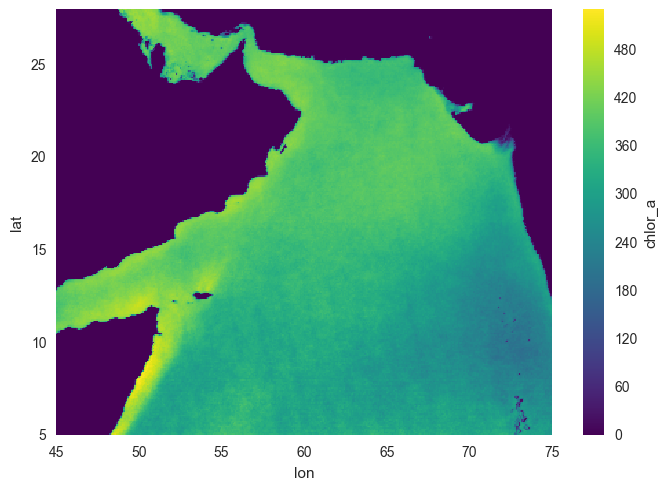

In [39]:
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


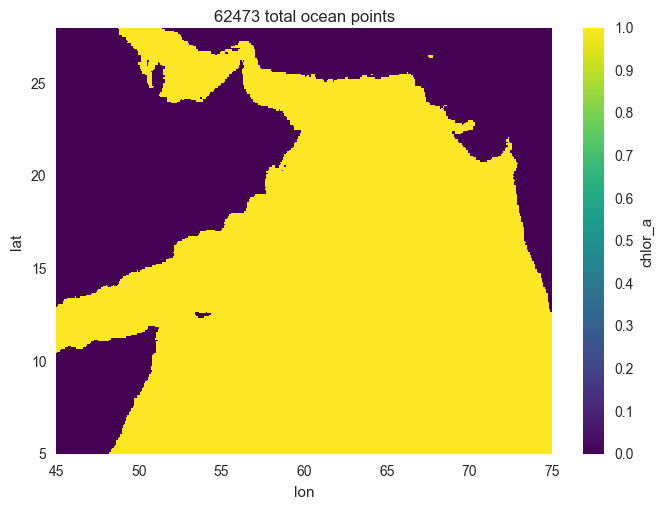

In [40]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
#ocean_mask = (ds_daily.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values  # compute the total nonzeros regions(data point)
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

In [41]:
#ds_8day

In [42]:
#ds_daily

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


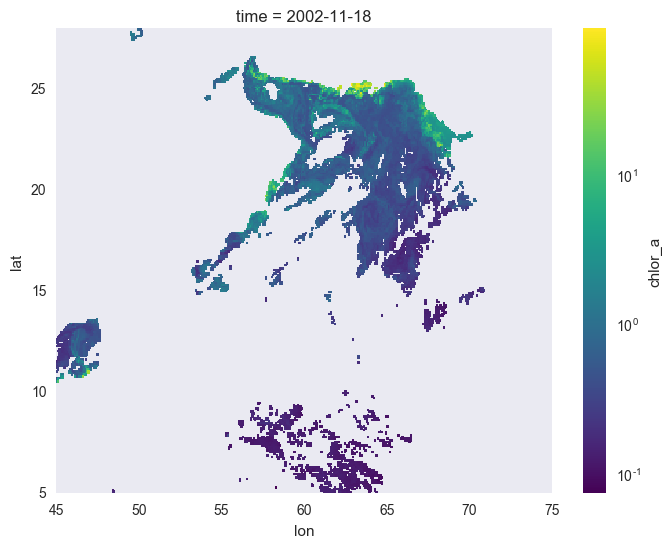

In [43]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())
#ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [44]:
#list(ds_daily.groupby('time')) # take a look at what's inside

Now we count up the number of valid points in each snapshot and divide by the total number of ocean points.

In [45]:
'''
<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 4748)
'''
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...
Data variables:
    palette  (time) int64 768 768 768 768 768 768 768 768 768 768 768 768 ...
    chlor_a  (time) int64 658 1170 1532 2798 2632 1100 1321 636 2711 1163 ...

In [46]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5295)>
array([ 0.01053255,  0.01872809,  0.02452259, ...,  0.        ,
        0.        ,  0.        ])
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...

In [47]:
count_8day,count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

In [48]:
#count_8day = ds_8day.chl_ocx.groupby('time').count()/float(num_ocean_points)
#coundt_daily = ds_daily.chl_ocx.groupby('time').count()/float(num_ocean_points)

#count_8day, coundt_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
#                            for ds in ds_8day, ds_daily] # not work in python 3


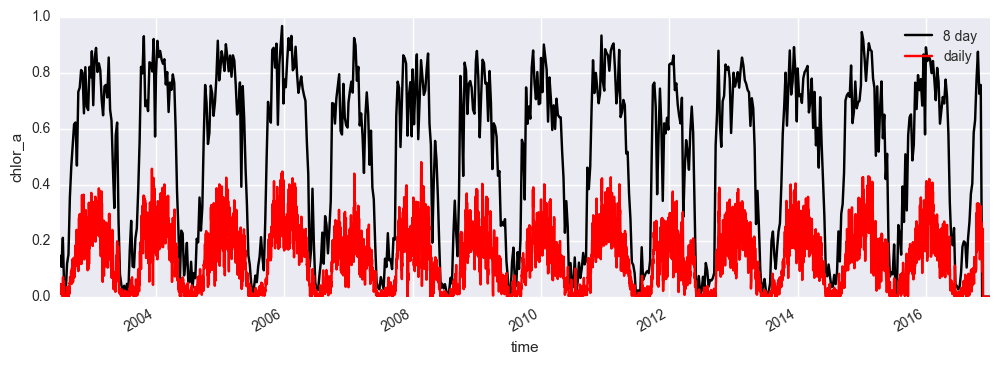

In [49]:
plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

## Seasonal Climatology

In [50]:
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()  # monthly data
                                      for count in (count_8day, count_daily)]

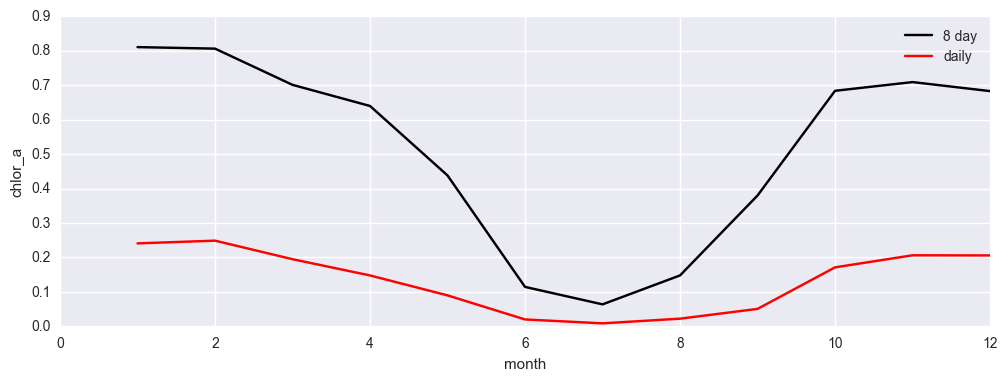

In [51]:
# mean value of the monthly data on the count of nonzeros
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

From the above figure, we see that data coverage is highest in the winter (especially Feburary) and lowest in summer.

## Maps of individual days

Let's grab some data from Febrauary and plot it.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


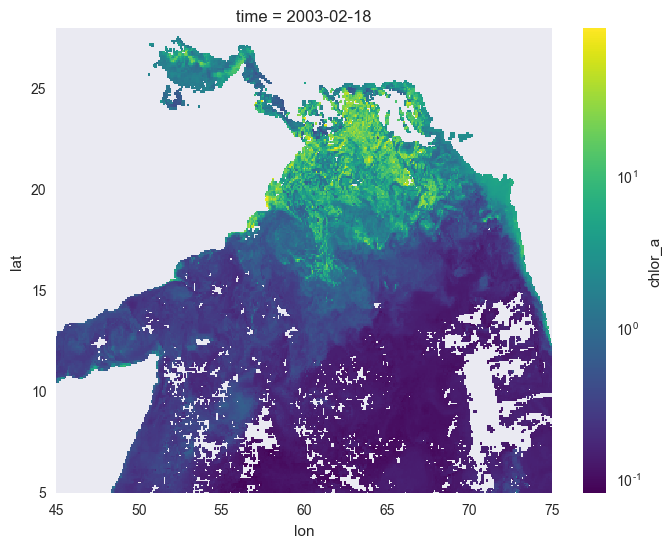

In [52]:
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


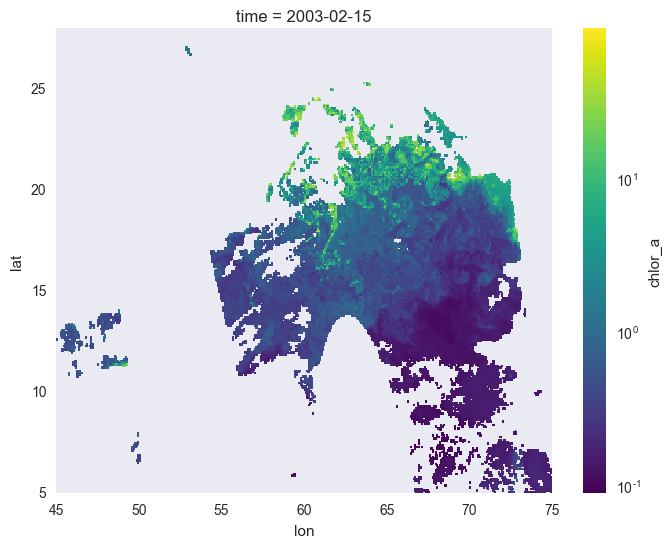

In [53]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [54]:
ds_daily.chlor_a[0].sel_points(lon=[65, 70], lat=[16, 18], method='nearest')   # the time is selected!
#ds_daily.chl_ocx[0].sel_points(time= times, lon=lons, lat=times, method='nearest')

<xarray.DataArray 'chlor_a' (points: 2)>
array([ nan,  nan])
Coordinates:
    time     datetime64[ns] 2002-07-04
    lat      (points) float64 16.04 18.04
    lon      (points) float64 65.04 70.04
  * points   (points) int64 0 1

In [55]:
df = pd.DataFrame([[1.4, np.nan], [7.1, -4.5], [np.nan, np.nan], [0.75, -1.3]], 
               index=['a', 'b', 'c', 'd'], columns=['one', 'two'])
df.mean(axis=1,skipna=None) # try skipna=False, skipna=True(seems to equiv to skipna=None)

a    1.400
b    1.300
c      NaN
d   -0.275
dtype: float64

In [56]:
ds_9day = ds_daily.resample('9D', dim='time')  # see the above for doc, test case, & default behavior
ds_9day

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 589)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 2002-07-04 2002-07-13 2002-07-22 ...
Data variables:
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...
    chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


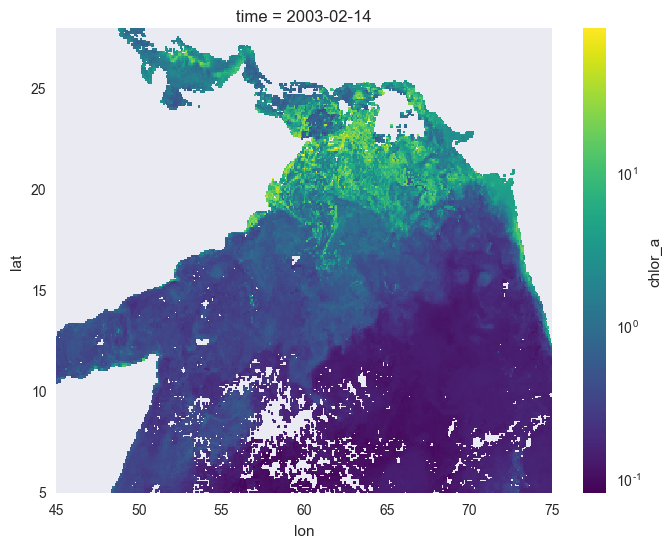

In [57]:
plt.figure(figsize=(8,6))
ds_9day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [58]:
# check the range for the longitude
print(ds_9day.lon.min(),'\n' ,ds_9day.lat.min())  

<xarray.DataArray 'lon' ()>
array(45.04166793823242) 
 <xarray.DataArray 'lat' ()>
array(5.041661739349365)


# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [59]:
# in the following we deal with the data from the gdp float
from buyodata import buoydata
import os

In [60]:
# a list of files
fnamesAll = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_15000.dat','./gdp_float/buoydata_15001_jun16.dat']

In [61]:
# read them and cancatenate them into one DataFrame
dfAll = pd.concat([buoydata.read_buoy_data(f) for f in fnamesAll])  # around 4~5 minutes

#mask = df.time>='2002-07-04' # we only have data after this data for chlor_a
dfvvAll = dfAll[dfAll.time>='2002-07-04']

sum(dfvvAll.time<'2002-07-04') # recheck whether the time is 

0

In [62]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(), dfvvAll.lon.max()))
mask = dfvvAll.lon<0
dfvvAll.lon[mask] = dfvvAll.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(),dfvvAll.lon.max()) )

dfvvAll.describe()

before processing, the minimum longitude is0.0000004.3 and maximum is 360.0000004.3


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/generic.py:4695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

after processing, the minimum longitude is 0.0000004.3 and maximum is 360.0000004.3


id           lat           lon          temp            ve  \
count  2.147732e+07  2.131997e+07  2.131997e+07  1.986179e+07  2.129142e+07   
mean   1.765662e+06 -2.263128e+00  2.124412e+02  1.986121e+01  2.454172e-01   
std    9.452835e+06  3.401115e+01  9.746941e+01  8.339498e+00  2.525050e+01   
min    2.578000e+03 -7.764700e+01  0.000000e+00 -1.685000e+01 -2.916220e+02   
25%    4.897500e+04 -3.186000e+01  1.490720e+02  1.437300e+01 -1.411400e+01   
50%    7.141300e+04 -4.920000e+00  2.153940e+02  2.214400e+01 -5.560000e-01   
75%    1.094330e+05  2.756000e+01  3.064370e+02  2.688900e+01  1.356100e+01   
max    6.399288e+07  8.989900e+01  3.600000e+02  4.595000e+01  4.417070e+02   

                 vn           spd       var_lat       var_lon       var_tmp  
count  2.129142e+07  2.129142e+07  2.147732e+07  2.147732e+07  2.147732e+07  
mean   4.708192e-01  2.613427e+01  7.326258e+00  7.326555e+00  7.522298e+01  
std    2.052160e+01  1.939087e+01  8.527853e+01  8.527851e+01  2.637454e+02  
min   -2.601400e+02  0.000000e+00  5.268300e-07 -3.941600e-02  1.001300e-03  
25%   -1.044700e+01  1.290300e+01  4.366500e-06  7.512600e-06  1.435700e-03  
50%    1.970000e-01  2.176700e+01  8.833600e-06  1.495800e-05  1.691700e-03  
75%    1.109300e+01  3.405900e+01  1.833300e-05  3.627900e-05  2.294200e-03  
max    2.783220e+02  4.421750e+02  1.000000e+03  1.000000e+03  1.000000e+03

In [63]:
# Select only the arabian sea region
arabian_sea = (dfvvAll.lon > 45) & (dfvvAll.lon< 75) & (dfvvAll.lat> 5) & (dfvvAll.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floatsAll = dfvvAll.loc[arabian_sea]   # directly use mask
print('dfvvAll.shape is %s, floatsAll.shape is %s' % (dfvvAll.shape, floatsAll.shape) )

dfvvAll.shape is (21477317, 11), floatsAll.shape is (111894, 11)


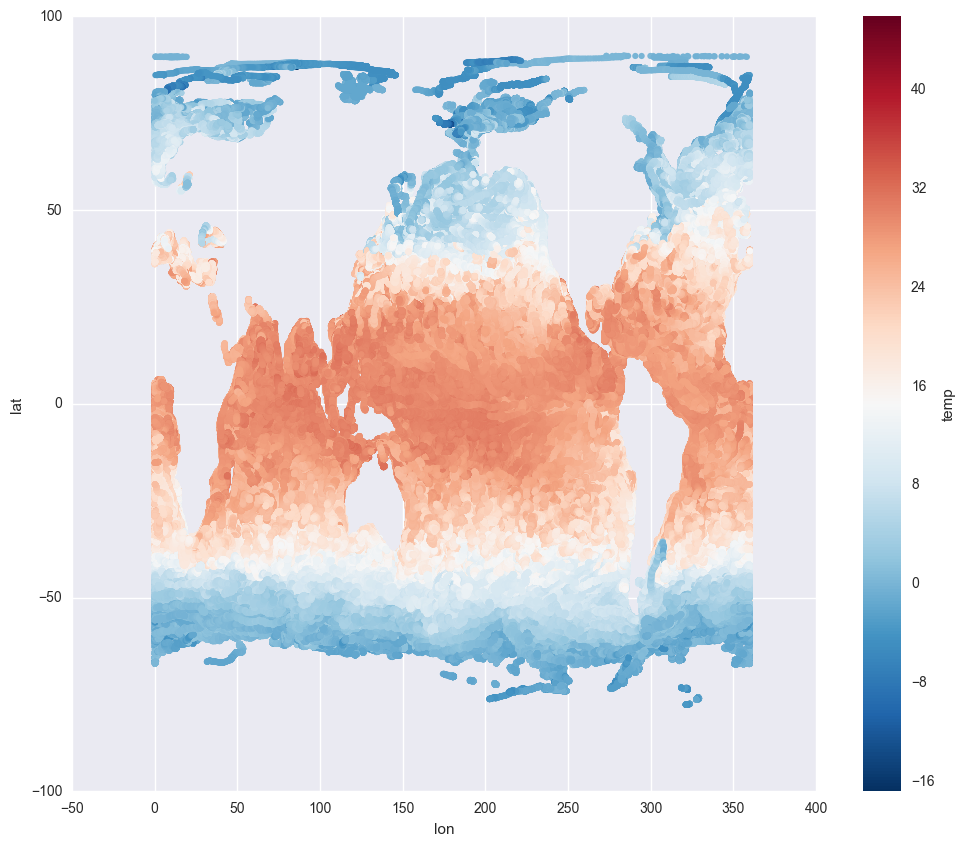

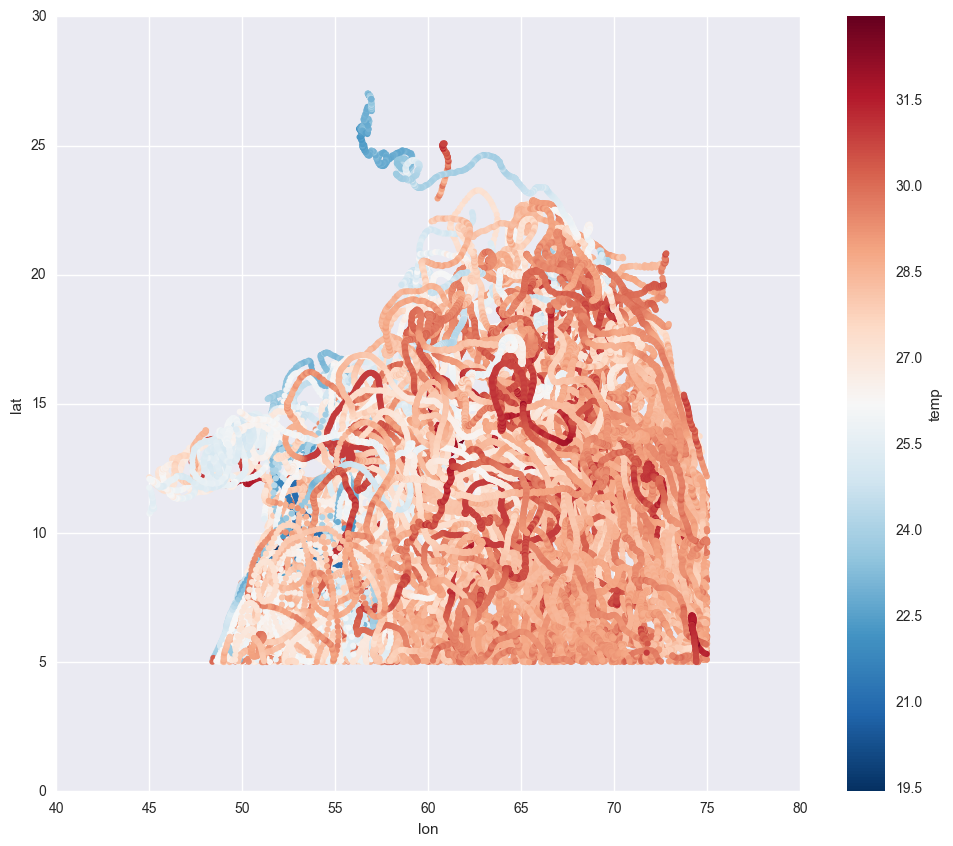

In [64]:
# visualize the float around global region
fig, ax  = plt.subplots(figsize=(12,10))
dfvvAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [65]:
# pands dataframe cannot do the resamplingn properly
# cause we are really indexing on ['time','id'], pandas.dataframe.resample cannot do this
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'
print()

In [66]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDSAll = xr.Dataset.from_dataframe(floatsAll.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDSAll

<xarray.Dataset>
Dimensions:  (id: 259, time: 17499)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-04T06:00:00 ...
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
Data variables:
    lat      (time, id) float64 nan 16.3 14.03 16.4 14.04 nan 20.11 nan ...
    lon      (time, id) float64 nan 66.23 69.48 64.58 69.51 nan 68.55 nan ...
    temp     (time, id) float64 nan nan nan 28.0 28.53 nan 28.93 nan 27.81 ...
    ve       (time, id) float64 nan 8.68 5.978 6.286 4.844 nan 32.9 nan ...
    vn       (time, id) float64 nan -13.18 -18.05 -7.791 -17.47 nan 15.81 ...
    spd      (time, id) float64 nan 15.78 19.02 10.01 18.13 nan 36.51 nan ...
    var_lat  (time, id) float64 nan 0.0002661 5.01e-05 5.018e-05 5.024e-05 ...
    var_lon  (time, id) float64 nan 0.0006854 8.851e-05 9.018e-05 8.968e-05 ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003733 0.0667 nan 0.001683 ...

In [67]:
floatsDSAll.dims

Frozen(SortedKeysDict({'time': 17499, 'id': 259}))

In [68]:
# resample on the xarray.dataset onto two-day frequency
floatsDSAll_9D =floatsDSAll.resample('9D', dim='time')
print(floatsDSAll_9D.dims)   # downsampling on the 'time' dimension 17499/9/4=  around 486
floatsDSAll_9D

Frozen(SortedKeysDict(OrderedDict([('id', 259), ('time', 568)])))


<xarray.Dataset>
Dimensions:  (id: 259, time: 568)
Coordinates:
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-13 2002-07-22 ...
Data variables:
    ve       (time, id) float64 nan 7.056 12.94 11.14 11.71 nan 24.13 nan ...
    var_lon  (time, id) float64 nan 0.005002 0.0001159 0.000123 9.882e-05 ...
    temp     (time, id) float64 nan nan nan 27.8 28.57 nan 28.98 nan 27.62 ...
    spd      (time, id) float64 nan 8.463 17.92 20.22 16.84 nan 25.5 nan ...
    vn       (time, id) float64 nan 0.02706 -8.271 -14.36 -7.037 nan -1.798 ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.00362 0.08884 nan 0.001708 ...
    lat      (time, id) float64 nan 16.22 13.6 16.07 13.64 nan 20.08 nan ...
    lon      (time, id) float64 nan 66.53 69.91 65.04 69.92 nan 69.45 nan ...
    var_lat  (time, id) float64 nan 0.001326 6.127e-05 6.456e-05 5.404e-05 ...

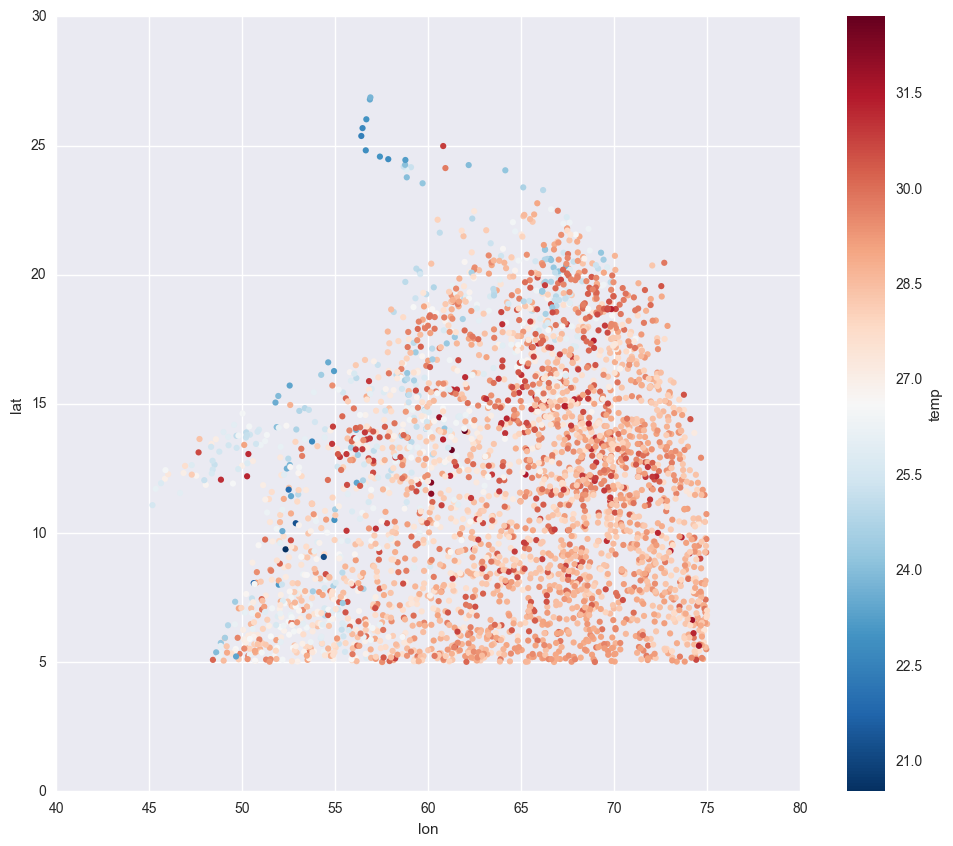

In [69]:
# transfer it back to pandas.dataframe for plotting
floatsDFAll_9D = floatsDSAll_9D.to_dataframe()
floatsDFAll_9D
floatsDFAll_9D = floatsDFAll_9D.reset_index()
floatsDFAll_9D
# visualize the subsamping of floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_9D.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [70]:
# get the value for the chlorophyll for each data entry
floatsDFAll_9Dtimeorder = floatsDFAll_9D.sort_values(['time','id'],ascending=True)
floatsDFAll_9Dtimeorder # check whether it is time ordered!!
# should we drop nan to speed up??

id       time         ve   var_lon       temp        spd  \
0           7574 2002-07-04        NaN       NaN        NaN        NaN   
568        10206 2002-07-04   7.056056  0.005002        NaN   8.462583   
1136       10208 2002-07-04  12.942722  0.000116        NaN  17.918639   
1704       11089 2002-07-04  11.143806  0.000123  27.796889  20.217250   
2272       15703 2002-07-04  11.706389  0.000099  28.572750  16.841889   
2840       15707 2002-07-04        NaN       NaN        NaN        NaN   
3408       27069 2002-07-04  24.130583  0.000102  28.981389  25.498500   
3976       27139 2002-07-04        NaN       NaN        NaN        NaN   
4544       28842 2002-07-04   5.026861  0.000208  27.620472  18.067944   
5112       34159 2002-07-04  31.753083  0.000112        NaN  37.039111   
5680       34173 2002-07-04        NaN       NaN        NaN        NaN   
6248       34210 2002-07-04  -3.750167  0.000124  26.452806  26.752611   
6816       34211 2002-07-04  23.260944  0.000102  28.380222  28.413083   
7384       34212 2002-07-04  42.864500  0.000100  28.577889  48.849444   
7952       34223 2002-07-04        NaN       NaN        NaN        NaN   
8520       34310 2002-07-04        NaN       NaN        NaN        NaN   
9088       34311 2002-07-04        NaN       NaN        NaN        NaN   
9656       34312 2002-07-04        NaN       NaN        NaN        NaN   
10224      34314 2002-07-04        NaN       NaN        NaN        NaN   
10792      34315 2002-07-04        NaN       NaN        NaN        NaN   
11360      34374 2002-07-04        NaN       NaN        NaN        NaN   
11928      34708 2002-07-04  30.589861  0.000109  27.291500  30.958611   
12496      34709 2002-07-04 -84.267000  0.000189  26.934000  96.889000   
13064      34710 2002-07-04   0.763722  0.000097  31.149000  47.400444   
13632      34714 2002-07-04  35.870556  0.000111  27.765694  37.025528   
14200      34716 2002-07-04  34.058694  0.000106  28.780944  37.381000   
14768      34718 2002-07-04  20.389944  0.000103  29.063444  39.619167   
15336      34719 2002-07-04  13.919778  0.000107  28.959417  27.380083   
15904      34720 2002-07-04  11.141528  0.000111  28.664167  24.609778   
16472      34721 2002-07-04   5.753667  0.000113  27.908083  13.113972   
...          ...        ...        ...       ...        ...        ...   
130639   3098682 2016-06-23        NaN       NaN        NaN        NaN   
131207  60073460 2016-06-23        NaN       NaN        NaN        NaN   
131775  60074440 2016-06-23        NaN       NaN        NaN        NaN   
132343  60077450 2016-06-23        NaN       NaN        NaN        NaN   
132911  60150420 2016-06-23        NaN       NaN        NaN        NaN   
133479  60454500 2016-06-23        NaN       NaN        NaN        NaN   
134047  60656200 2016-06-23        NaN       NaN        NaN        NaN   
134615  60657200 2016-06-23        NaN       NaN        NaN        NaN   
135183  60658190 2016-06-23        NaN       NaN        NaN        NaN   
135751  60659110 2016-06-23        NaN       NaN        NaN        NaN   
136319  60659120 2016-06-23        NaN       NaN        NaN        NaN   
136887  60659190 2016-06-23        NaN       NaN        NaN        NaN   
137455  60659200 2016-06-23        NaN       NaN        NaN        NaN   
138023  60940960 2016-06-23        NaN       NaN        NaN        NaN   
138591  60940970 2016-06-23        NaN       NaN        NaN        NaN   
139159  60941960 2016-06-23        NaN       NaN        NaN        NaN   
139727  60941970 2016-06-23        NaN       NaN        NaN        NaN   
140295  60942960 2016-06-23        NaN       NaN        NaN        NaN   
140863  60942970 2016-06-23        NaN       NaN        NaN        NaN   
141431  60943960 2016-06-23        NaN       NaN        NaN        NaN   
141999  60943970 2016-06-23        NaN       NaN        NaN        NaN   
142567  60944960 2016-06-23        NaN       NaN        NaN        NaN   
143135  60944970 2

In [558]:
'''
<xarray.Dataset>
Dimensions:  (id: 259, time: 568)   # 259*568
'''
floatsDFAll_9Dtimeorder.lon.shape

(147112,)

In [72]:
# can we try to fit the missing value at thisstep
floatsDFAll_9Dtimeorder.lon.dropna().shape  # the longitude data has lots of values (3466,)

(3466,)

In [73]:
############ interpolation starts from here

          id       time  ve  var_lon  temp  spd  vn  var_tmp  lat  lon  \
56800  62558 2002-07-04 NaN      NaN   NaN  NaN NaN      NaN  NaN  NaN   
57368  63036 2002-07-04 NaN      NaN   NaN  NaN NaN      NaN  NaN  NaN   
57936  63067 2002-07-04 NaN      NaN   NaN  NaN NaN      NaN  NaN  NaN   
58504  63068 2002-07-04 NaN      NaN   NaN  NaN NaN      NaN  NaN  NaN   
59072  63069 2002-07-04 NaN      NaN   NaN  NaN NaN      NaN  NaN  NaN   

       var_lat  
56800      NaN  
57368      NaN  
57936      NaN  
58504      NaN  
59072      NaN  


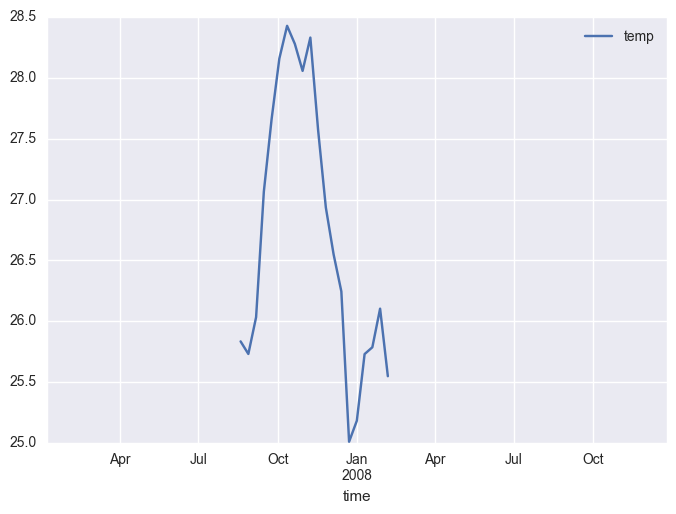

In [74]:
# to understand the float data better
# a: Look into the floatsDFAll_9Dtimeorder data in more details
# check the nan counts in each id
# plot the trajectory of {time, lat, lon, temperature,} for each float id,  
# this steps helps to understand the float dataset and if there is a need, improve it.

# b: take the float data as it is, and do the interpolation, whenever there is a nan value use the nearest neigbhours....
# check whether the quality of interpolataion is improved, if not, then have to fall back to to task 1

# c: vectorization

# DataFrame panel data 
# floatsDFAll_9Dtimeorder.set_index(['id','time']) 
# the inverse operation # floatsDFAll_9Dtimeorder.reset_index()
# look into the data
print(floatsDFAll_9Dtimeorder[100:105])
# so far there is no need to convert it into a panel 
# floatsDFAll_9DtimeorderPanel = floatsDFAll_9Dtimeorder.to_panel

# plot the temperature for one float, the temperature do have a trend
maskid = (floatsDFAll_9Dtimeorder.id == 63069) & (floatsDFAll_9Dtimeorder.time> '2007-01-01') & (floatsDFAll_9Dtimeorder.time< '2009-01-01')
floatsDFAll_9Dtimeorder[maskid]
floatsDFAll_9Dtimeorder[maskid].plot(x='time', y ='temp')

In [75]:
# this is a float that explains the need for temperature data
maskid2 = floatsDFAll_9Dtimeorder.id == 10208
floatsDFAll_9Dtimeorder[maskid2].head()

id       time         ve   var_lon  temp        spd         vn  \
1136  10208 2002-07-04  12.942722  0.000116   NaN  17.918639  -8.270944   
1137  10208 2002-07-13   8.819778  0.000113   NaN  12.927639  -5.433167   
1138  10208 2002-07-22  -1.535306  0.000127   NaN  25.644722 -21.372750   
1139  10208 2002-07-31   1.551611  0.000135   NaN  32.618917 -31.578528   
1140  10208 2002-08-09  12.855500  0.000125   NaN  15.766083  -7.338472   

      var_tmp        lat        lon   var_lat  
1136   1000.0  13.599500  69.914139  0.000061  
1137   1000.0  13.412417  70.726278  0.000060  
1138   1000.0  12.617778  71.035056  0.000066  
1139   1000.0  10.364833  70.913944  0.000069  
1140   1000.0   9.144639  71.453528  0.000065

In [77]:
################
# test case 1: take a single entry (southeast corner for valid values)
row_case1 =  pd.DataFrame(data = {'time':'2002-07-13 00:00:00', 'id': 10206, 'lon':74.7083358765, 'lat':5.20833349228},index=[1])
print(row_case1)

################
# test case 2
# take a {time-list, id-list, lon-list, lat-list}, index-list 
# carry out the interpolation
#row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00','2002-07-22 00:00:00'] , 'id': [10206, 10206], 'lon':[74.7083358765, 74.6250076294], 'lat':[5.20833349228, 5.29166173935]},index=[2,3])
#print(row_case2)
################
# test case 3
row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00'] , 'id': [10206, 10206, 10206], 'lon':[74.7083358765, 74.6250076294,74.7083358765], 'lat':[5.20833349228, 5.29166173935, 5.20833349228]},index=[1,2,3])
print(row_case2)



####
## get the indices of time, lat, lon
idx_time = ds_9day.indexes['time'] 
idx_lat = ds_9day.indexes['lat']
idx_lon = ds_9day.indexes['lon']

#### 
#interpolation on the time dimension
time_len = len(row_case2.time.values)
xtime_test = list([ np.datetime64(row_case2.time.values[i]) for i in range(0,time_len)  ] )  # for delta 
print('\n xtime_test \n', xtime_test)

'''caution: cannot do this inside the function get_loc,
see https://github.com/pandas-dev/pandas/issues/3488
'''
itime_nearest = [idx_time.get_loc(xtime_test[i], method='nearest') for i in range(0, time_len)]
print('\n itime_nearest \n', itime_nearest)  # [1,2]

xtime_nearest =  ds_9day.time[itime_nearest].values  #  ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('\n xtime_nearest\n', xtime_nearest)  # ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('xtime_nearest', type(xtime_nearest)) # xtime_nearest <class 'numpy.ndarray'> # time_nearest <class 'numpy.datetime64'>

# the time distance in days
delta_xtime = (xtime_test - xtime_nearest) / np.timedelta64(1, 'D')
print('\n delta_xtime in days \n', delta_xtime)
print(type(delta_xtime))

itime_next = [itime_nearest[i]+1 if  delta_xtime[i] >=0  else itime_nearest[i]-1  for i in range(0, time_len) ]
print('\n itime_next \n',itime_next)  # [2, 3]

# find the next coordinate values
xtime_next = ds_9day.time[itime_next].values
print('\n xtime_next \n', xtime_next) # ['2002-07-22T00:00:00.000000000' '2002-07-31T00:00:00.000000000']

# prepare for the Tri-linear interpolation
base_time = (xtime_next - xtime_nearest) / np.timedelta64(1, 'D')  # [ 9.  9.]
print('\n base_time \n', base_time)
w_time = delta_xtime / base_time  
print('\n w_time \n', w_time) # [ 0.  0.]


#### 
#interpolation on the lat dimension
xlat_test = row_case2.lat.values + 0.06   # base [ 5.20833349  5.29166174] # cell distance around .8, use .2 & .6 as two tests
print('\n xlat_test \n', xlat_test)       # xlat_test [ 5.26833349  5.35166174]

ilat_nearest = [idx_lat.get_loc(xlat_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilat_nearest \n', ilat_nearest) # [272, 271]

xlat_nearest = ds_9day.lat[ilat_nearest].values  
print('\n xlat_nearest \n', xlat_nearest) # [ 5.29166174  5.37499762]

delta_xlat = xlat_test - xlat_nearest
print("\n delta_xlat \n",delta_xlat)      #  [-0.02332825 -0.02333588]


# the nearest index is on the right; but order of the latitude is different, it is descending
ilat_next = [ilat_nearest[i]-1 if  delta_xlat[i] >=0  else ilat_nearest[i]+1  for i in range(0, time_len) ]
print('\n ilat_next \n', ilat_next)  # [273, 272]

# find the next coordinates value
xlat_next = ds_9day.lat[ilat_next].values
print('\n xlat_next \n', xlat_next)  # [ 5.20833349  5.29166174]

# prepare for the Tri-linear interpolation
w_lat = delta_xlat / (xlat_next - xlat_nearest)
print('\n w_lat \n', w_lat) # [ 0.27995605  0.28002197]

#### 
#interpolation on the lon dimension
xlon_test = row_case2.lon.values +0.06 # base [74.7083358765, 74.6250076294] # cell distance around .8, use .2 & .6 as two tests
print('\n xlon_test \n', xlon_test)  # [ 74.76833588  74.68500763]

ilon_nearest = [idx_lon.get_loc(xlon_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilon_nearest \n', ilon_nearest) # [357, 356]

xlon_nearest = ds_9day.lon[ilon_nearest].values  
print('\n xlon_nearest \n', xlon_nearest) # [ 74.79166412  74.70833588]

delta_xlon = xlon_test - xlon_nearest     
print("\n delta_xlon \n", delta_xlon)     #  [-0.02332825 -0.02332825]

ilon_next = [ilon_nearest[i]+1 if  delta_xlon[i] >=0  else ilon_nearest[i]-1  for i in range(0, time_len) ]
print('\n ilon_next \n',ilon_next)  # [356, 355]

# find the next coordinate values
xlon_next = ds_9day.lon[ilon_next].values
print("\n xlon_next \n", xlon_next) # [ 74.70833588  74.62500763]

# prepare for the Tri-linear interpolation
w_lon = delta_xlon / (xlon_next - xlon_nearest)
print("\n w_lon \n", w_lon) # [ 0.27995605  0.27995605]

####
# local Tensor product for Trilinear interpolation
# caution: nan values, store as "list_of_array to 2d_array" first, then sum

# no casting to list needed here, inputs are already lists
tmp = np.array([
         ds_9day.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_9day.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_next).values,
         ds_9day.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_nearest).values,
         ds_9day.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_next).values,
         ds_9day.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_9day.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_next).values,
         ds_9day.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_nearest).values,
         ds_9day.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_next).values ])

weights =  np.array([(1-w_time)*(1-w_lat)*(1-w_lon), 
                     (1-w_time)*(1-w_lat)*w_lon,
                     (1-w_time)*w_lat*(1-w_lon), 
                     (1-w_time)*w_lat*w_lon,
                        w_time*(1-w_lat)*(1-w_lon),
                        w_time*(1-w_lat)*w_lon,
                        w_time*w_lat*(1-w_lon),
                        w_time*w_lat*w_lon ])


# how to deal with "nan" values, fill in missing values for the np.array tmpAll 
# or fill the mean values to the unweighted array
# http://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns

print('\n neighbouring tensor used \n', tmp)
'''
 neighbouring tensor used 
 [[        nan  0.181841  ]
 [ 0.245878           nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.19680101         nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.18532801         nan]]
'''

# column min: (nan+0.245878 + nan + nan + 0.19680101 + nan +  nan + 0.18532801)/8 = 0.20933567333
col_mean = np.nanmean(tmp, axis=0)
print('\n its mean along axis 0(column) \n', col_mean)  #  [ 0.20933567  0.181841  ]


# filling the missing values.
inds = np.where(np.isnan(tmp))
print('\n nan index\n', inds)
tmp[inds]=np.take(col_mean, inds[1])
print('\n values after the fill \n', tmp)

print('\n weighting tensor used \n', weights)

print("weights.shape", weights.shape) # (8, 3)
print("tmp.shape", tmp.shape)  # (8, 3)

nrow_w, ncol_w = weights.shape
nrow_t, ncol_t = tmp.shape
assert nrow_w == nrow_t, "the row count of weights and values are not the same!"
assert ncol_w == ncol_t, "the row count of weights and values are not the same!"
print('\n tensor product\n', np.dot(weights[:,0], tmp[:,0]) ) # 0.216701896135 should be [ 0.2167019]

# new interpolation process of the Chl_a
chl_new = np.empty(ncol_w)
for i in range(0, ncol_w, 1):
    chl_new[i] =  np.dot(weights[:,i], tmp[:,i])

print('chl_newInt',  chl_new) #  [ 0.2167019  0.181841   0.2167019]
# validate by 1D array
# val = np.array([0.20933567, 0.245878,  0.20933567,
#                0.20933567, 0.19680101, 0.20933567,
#               0.20933567,0.18532801]) 
# np.dot(val, weights) # 0.21670189702309739


## output xarray.dataarray of points, see examples below
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['points'], np.random.randn(3))},
                        coords={
                                'time':(['points'],['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00']) , 
                                'id': (['points'], [10206, 10206, 10206]), 
                                'lon': (['points'], [74.7083358765, 74.6250076294,74.7083358765]),
                                'lat':(['points'], [5.20833349228, 5.29166173935, 5.20833349228]), 
                                'points': (['points'], [0,1,2])}) # this way the dims is set to point

print('\n',chl_newInt.chl)
'''
### Task: output xarray.dataarray as points
## example 1
arr = xr.DataArray(np.random.rand(4,3), [('time', pd.date_range('2000-01-01', periods=4)), ('space', ['IA', 'IL', 'IN'])] )
print("first example",arr)
print("\n \n")

## example2 -- concrete xr.DataArray
data = np.random.rand(4, 3)
locs = ['IA', 'IL', 'IN']
times = pd.date_range('2000-01-01', periods=4)
brr = xr.DataArray(data, coords={'time': times, 'space': locs, 'const': 42, \
                          'ranking': ('space', [1, 2, 3])}, \
             dims=['time', 'space'])
print("second example",brr)
'''

'''
### the target output
#the output generated by the xarray.DataSet => xarray.DataArray
<xarray.DataArray 'chlor_a' (points: 147112)>
array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
Coordinates:
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
    lon      (points) float64 74.96 66.54 69.88 65.04 69.88 74.96 69.46 ...
    lat      (points) float64 27.96 16.21 13.62 16.04 13.62 27.96 20.04 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  
### the solution approach we tried to is: first,  generate a xarray.DataSet
                                          second, generte a xarray.DataArray from the xarray DataSet if needed.
 
# 1. looking at this example, DataArray seems to be working.

# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

##########
# but not works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  np.array([10206, 10206, 10206])} )
print('\n da_test1', da_test1)

# err's
##########

##########
# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

# da_test1 <xarray.DataArray (x: 3)>
# array([ 0.90386212,  0.21516239,  0.44707272])
# Coordinates:
#   * x        (x) int64 10206 10206 10206
#     y        int64 2
##########

##########
# so we do this
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['id'], np.random.randn(3))},
                        coords={ 
                           'id':  (['id'], np.array([10206, 10206, 10206])), 
                           'lon': (['id'], np.array([74.7083358765, 74.6250076294,74.7083358765])), 
                           'lat': (['id'], np.array([5.20833349228, 5.29166173935, 5.20833349228]))})
print('chl_newInt', chl_newInt) # generate the xarray.DataSet
print('\n \n')
print('chl_newInt.chl', chl_newInt.chl) # xarray.DataSet contains many xarray.DataArray


#chl_newInt <xarray.Dataset>
#Dimensions:  (id: 3)
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208
#Data variables:
#    chl      (id) float64 0.783 -0.9714 -0.3206



#chl_newInt.chl <xarray.DataArray 'chl' (id: 3)>
#array([ 0.78301614, -0.97144208, -0.3206447 ])
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208

'''
print()

      id       lat        lon                 time
1  10206  5.208333  74.708336  2002-07-13 00:00:00
      id       lat        lon                 time
1  10206  5.208333  74.708336  2002-07-13 00:00:00
2  10206  5.291662  74.625008  2002-07-22 00:00:00
3  10206  5.208333  74.708336  2002-07-13 00:00:00

 xtime_test 
 [numpy.datetime64('2002-07-13T00:00:00'), numpy.datetime64('2002-07-22T00:00:00'), numpy.datetime64('2002-07-13T00:00:00')]

 itime_nearest 
 [1, 2, 1]

 xtime_nearest
 ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000'
 '2002-07-13T00:00:00.000000000']
xtime_nearest <class 'numpy.ndarray'>

 delta_xtime in days 
 [ 0.  0.  0.]
<class 'numpy.ndarray'>

 itime_next 
 [2, 3, 2]

 xtime_next 
 ['2002-07-22T00:00:00.000000000' '2002-07-31T00:00:00.000000000'
 '2002-07-22T00:00:00.000000000']

 base_time 
 [ 9.  9.  9.]

 w_time 
 [ 0.  0.  0.]

 xlat_test 
 [ 5.26833349  5.35166174  5.26833349]

 ilat_nearest 
 [272, 271, 272]

 xlat_nearest 
 [ 5.29166174  5.3

In [419]:
### output benchmark
### output the dataset ds_9day and output the dataframe  
#ds_9day.to_netcdf("ds_9day.nc")

#row_case4 = pd.DataFrame(data={'time':list(floatsDFAll_9Dtimeorder.time), 'lon':list(floatsDFAll_9Dtimeorder.lon), 'lat':list(floatsDFAll_9Dtimeorder.lat), 'id':list(floatsDFAll_9Dtimeorder.id) } )
##print('\n before dropping nan \n', row_case4)
## process to drop nan in any of the columns [id], [lat], [lon], [time]
#row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
#row_case4.to_csv("row_case4.csv")

In [159]:
#### the approach using Linear Interpolations with 3D tensors
# Keyword Arguments
# approach 1 
# each of the indexers component might be ordered differently
#############
# def sel_points_multilinear(dset, dims='points', out = 'str', **indexers):
## test case
# def sel_points_multilinear(ds_9day, dims = 'points', out ='chlor_a', 
#                            time = list(['2002-07-13 00:00:00']),
#                            lat = list([5]),  lon = list([70]) ):
############
# e.g. time-ascending, lat-descending, need to tell 'time' from 'lat'
# use different parameters for inputs
## approach 2 
## from dataframe to dataset
## input:
##     dframe: list of {time}, {lan}, {lon}, {id}. bounds-aware
##     dset:   carry out the interpolation use dset data structure and its component 
## output:
##     a list or dataframe with chl_newInt.chl

# remember to take log_e instead of log_10

# clean up this notebook, seperate, clean, and take notes

# test case 4: use the full real data
#del(interpolate)
#del(sel_points_multilinear)
# froms dir import src  # to call src.functions
from tools.time_lat_lon_interpolate import interpolate
import importlib
importlib.reload(interpolate)


row_case4 = pd.DataFrame(data={'time':list(floatsDFAll_9Dtimeorder.time), 'lon':list(floatsDFAll_9Dtimeorder.lon), 'lat':list(floatsDFAll_9Dtimeorder.lat), 'id':list(floatsDFAll_9Dtimeorder.id) } )
# process to drop nan in any of the columns [id], [lat], [lon], [time]
row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
# print('\n after dropping nan \n', row_case4)
result_out4 = interpolate.sel_points_multilinear_time_lat_lon(ds_9day, row_case4, dims = 'points', col_name ='chlor_a')
print('\n *** after the interpolation *** \n', result_out4)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(row_case4.index), len(result_out4.points) ) )  


 *** after the interpolation *** 
 <xarray.Dataset>
Dimensions:  (points: 3440)
Coordinates:
    lat      (points) float64 16.22 13.6 16.07 13.64 20.08 18.62 12.89 6.022 ...
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    lon      (points) float64 66.53 69.91 65.04 69.92 69.45 60.83 59.74 ...
    id       (points) int64 10206 10208 11089 15703 27069 28842 34159 34210 ...
Data variables:
    chlor_a  (points) float64 nan nan nan nan nan nan nan 0.3111 0.1214 ...

 *** this two length should be equal *** 3466 >= 3440?


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [160]:
plt.close("all")


 ******* The Multilinear Interpolation Approach ******* 


 ******* Adding the chlor_a ******* 

shape of the interpolation dateframe (2373, 5)
         chlor_a        lat       time        lon       id
points                                                    
7       0.311111   6.022361 2002-07-04  56.763194    34210
8       0.121357   8.210750 2002-07-04  68.565389    34211
9       0.119870   6.679556 2002-07-04  65.946111    34212
20      0.135519   9.076889 2002-07-04  63.827222  2134712
27      1.039728  14.227972 2002-07-13  62.072750    34159
28      0.276088   5.166000 2002-07-13  56.681857    34210
30      0.136596   6.276583 2002-07-13  68.507861    34212
32      0.150643   9.533636 2002-07-13  65.273364    34312
33      0.257518   5.116600 2002-07-13  54.903200    34314
34      0.140667   5.181103 2002-07-13  59.701448    34315
36      0.202289   6.426333 2002-07-13  52.779556    34709
38      0.173686  13.695556 2002-07-13  67.048250    34714
40      0.453930  12.430861 2

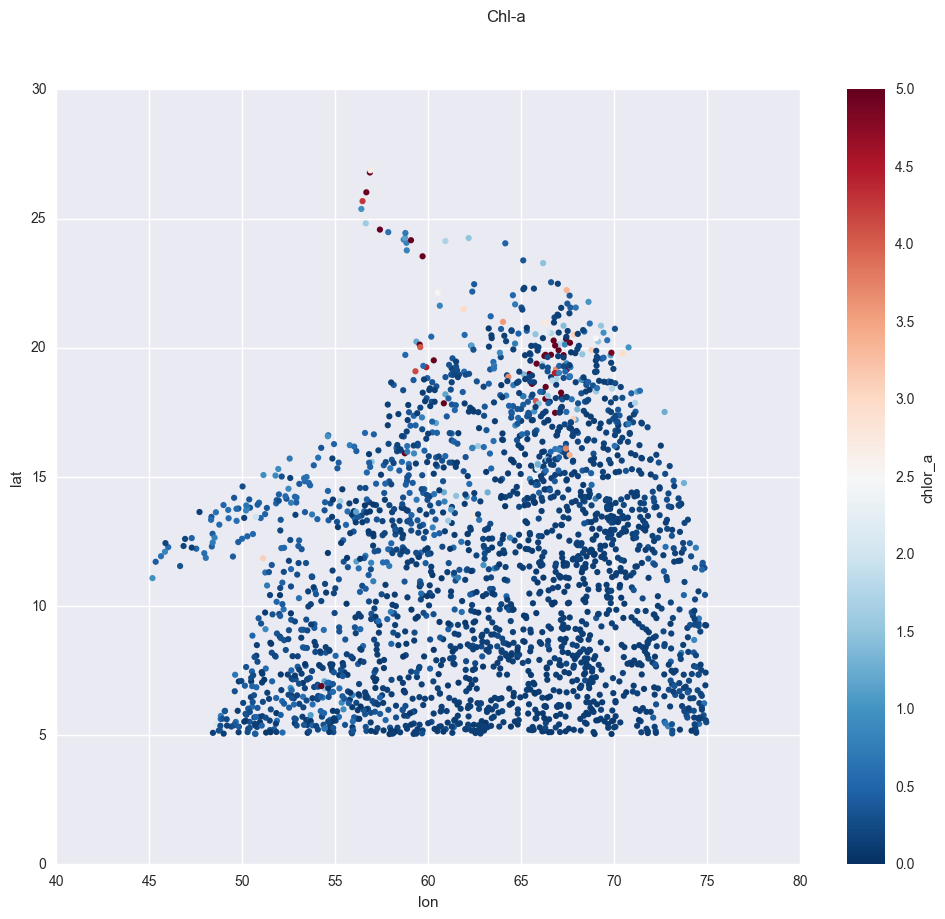

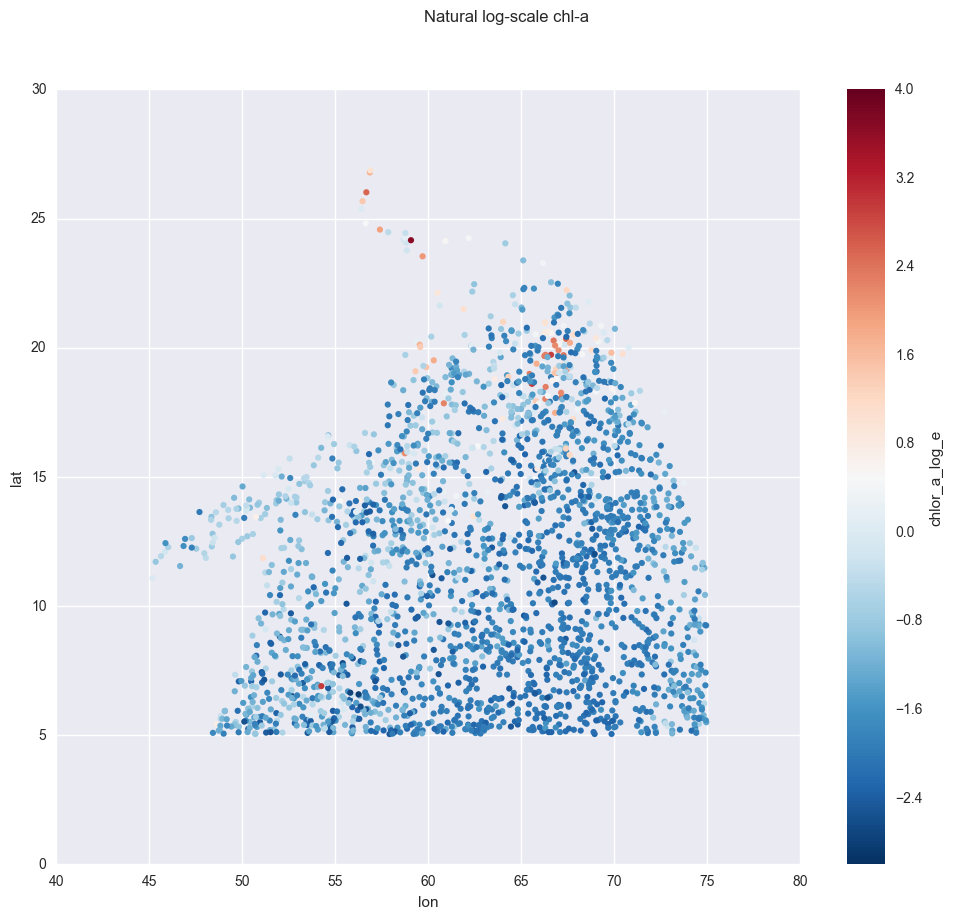

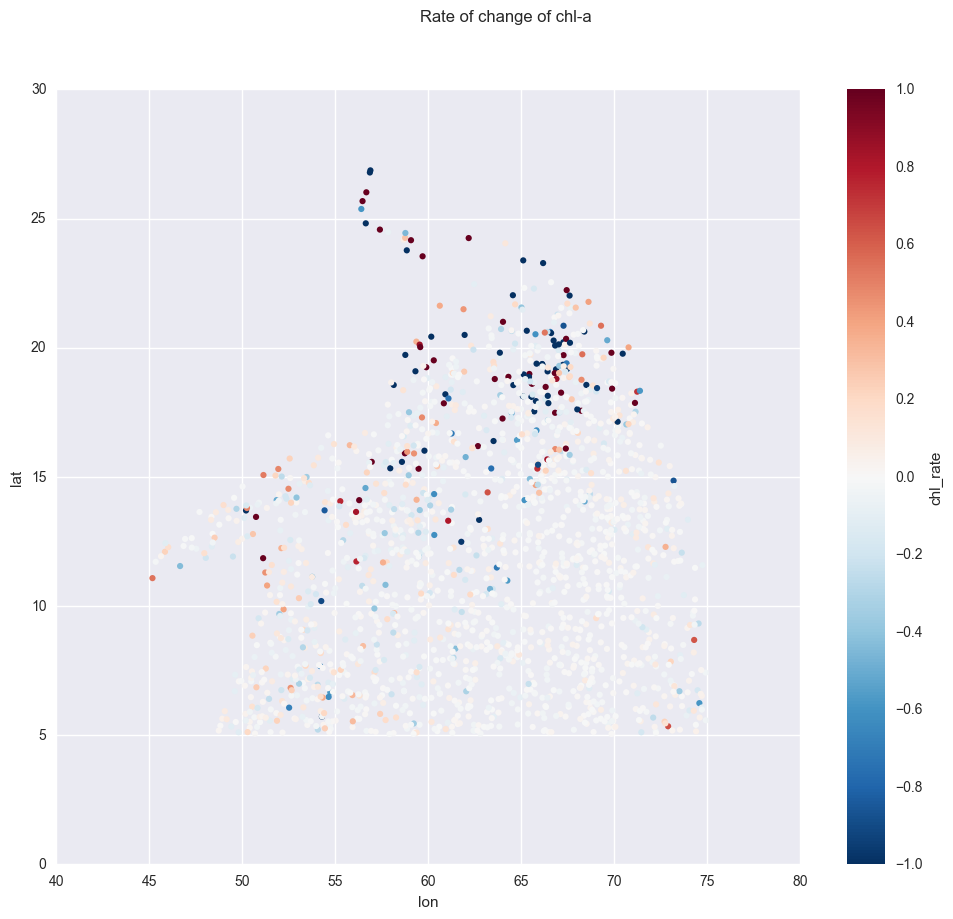

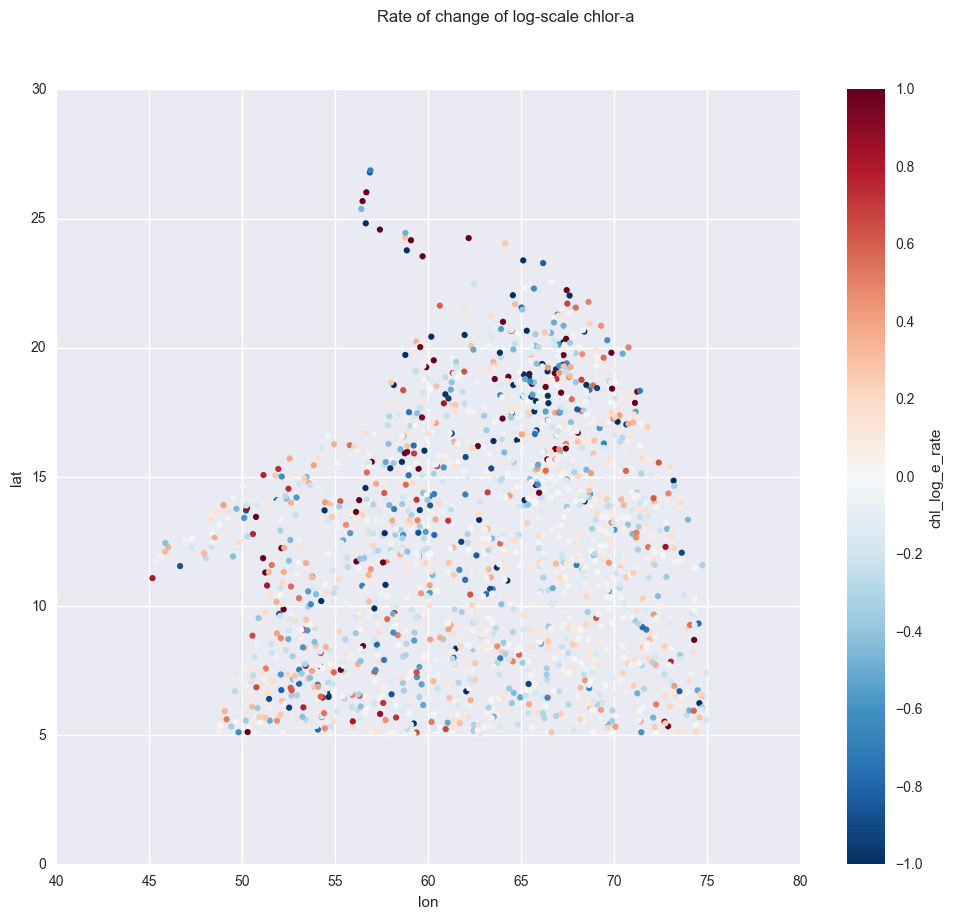


 ******* Select from November-01 to March-31 ******* 

shape of the selector (147112,)
all the data count during 'Nov-01 to Mar-31' is (977,)
all the data count is (1838,)

 ******* histogram of the rate of change of chl-a ******* 


 ** summary of chl_rate ** 
 count    977.000000
mean      -0.072522
std        2.489400
min      -37.495630
25%       -0.047762
50%       -0.003051
75%        0.038364
max       30.533662
Name: chl_rate, dtype: float64


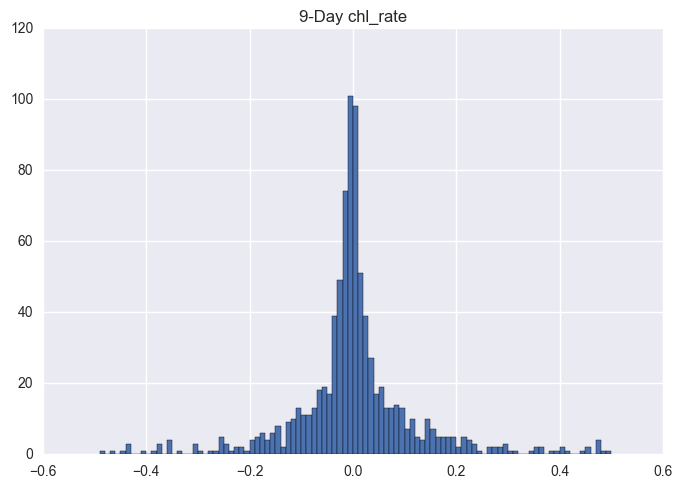


 ** summary of standardized chl_rate ** 
 count    9.770000e+02
mean    -2.378897e-17
std      1.000000e+00
min     -1.503298e+01
25%      9.946210e-03
50%      2.790705e-02
75%      4.454353e-02
max      1.229460e+01
Name: chl_rate, dtype: float64


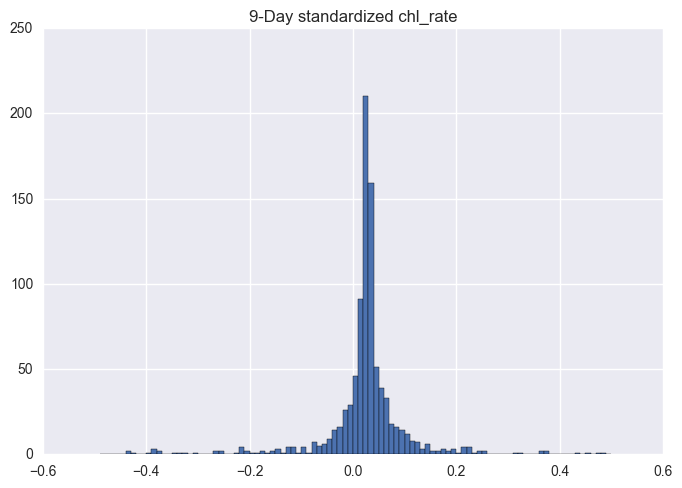


 ******* subplots of the rate of change of chl-a for different years ******* 


 count of data points for each year: 

(119,)
(65,)
(28,)
(72,)
(165,)
(189,)
(246,)
(86,)
(108,)
(60,)
(50,)
(46,)
(352,)
(172,)
(68,)


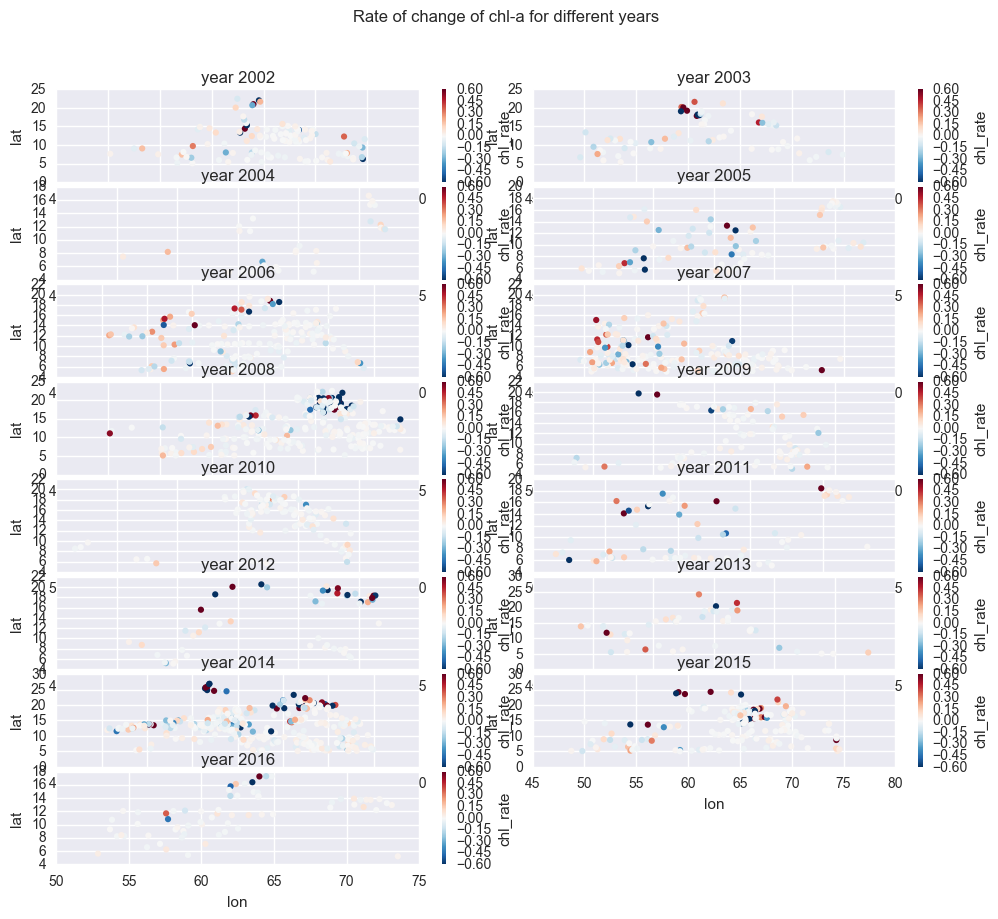


 count of data points during 'November-March' for each year: 

(82,)
(2,)
(19,)
(93,)
(69,)
(199,)
(41,)
(70,)
(9,)
(61,)
(0,)
(136,)
(130,)
(66,)


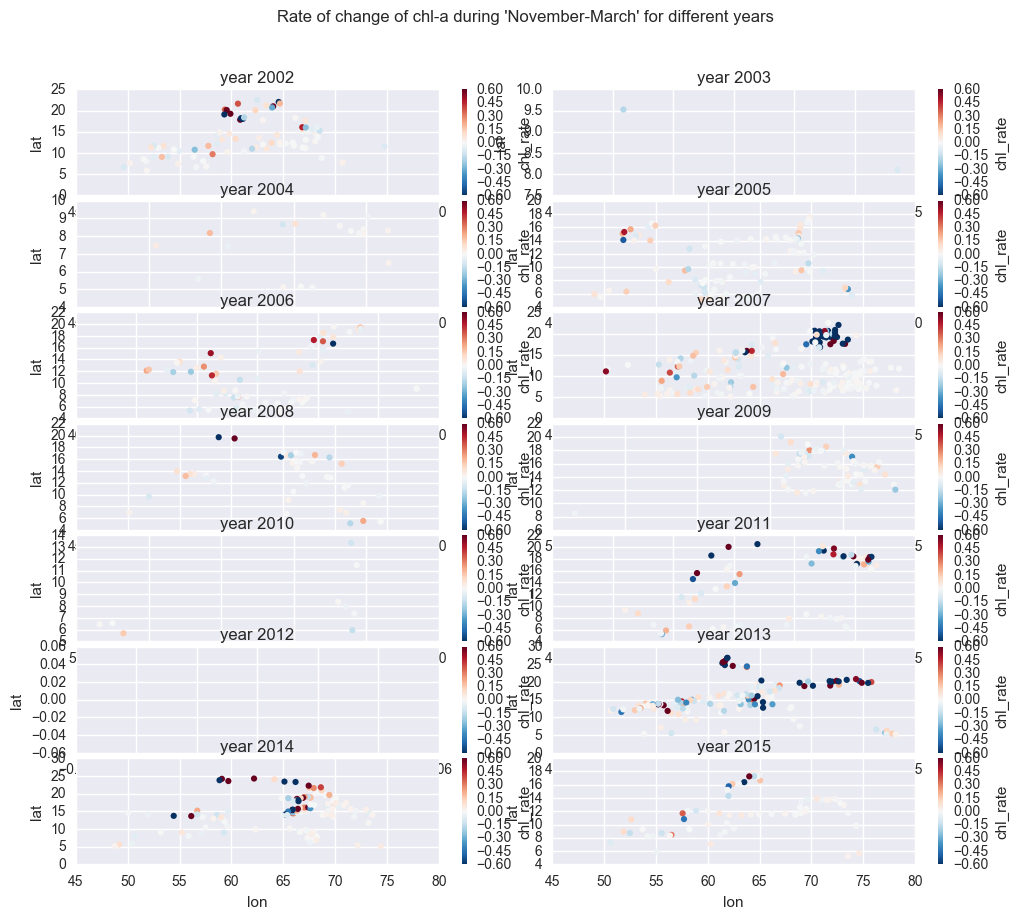


 ******* Reduce the Dataset to 'Nov-01 to Mar-31' ******* 

all the data count in [11-01, 03-31]  is  (977,)

 ******* Nondimensionalize chl_rate and chl_log_e_rate ******* 


 **** Adding the 'rotated week no.'; Nov-1 is week no.1 **** 

the min and max of the week index is 1, 53 :

 ****** dataset with the week no. added ****** 
                id         ve   var_lon       temp        spd         vn  \
time                                                                      
2002-11-07  11089 -16.412472  0.000123  28.829472  17.995028  -3.991722   
2002-11-07  34315 -20.578111  0.000110  29.388111  49.858889  34.961278   
2002-11-07  34710  -2.827667  0.000135  28.448167  20.774778  19.539861   
2002-11-07  34721   8.990500  0.000123  29.350472  17.351972   8.829861   
2002-11-16  11089 -31.654667  0.000118  28.117056  34.741278 -12.020361   
2002-11-16  34315  24.798806  0.000131  28.725000  29.896389  -5.815111   
2002-11-16  34710 -22.552528  0.000145  27.578250  50.700222  43.

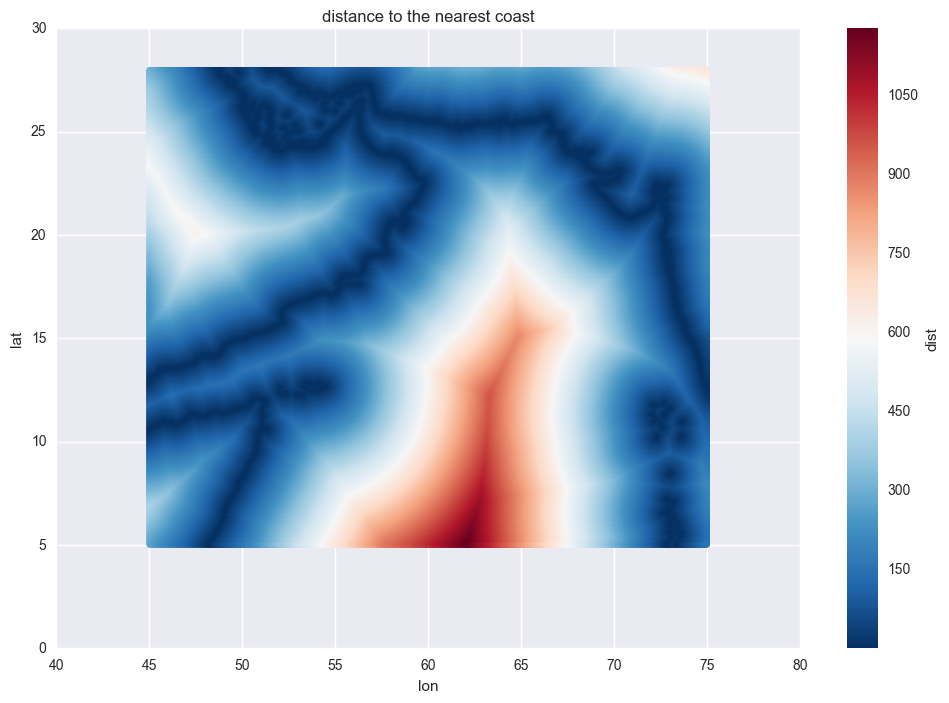


 ******** Interpolation of distance using (lat, lon) ******* 


 <xarray.DataArray 'dist' (points: 1197)>
array([ 541.73245556,  872.17759663,  572.60639866, ...,  393.90404265,
        681.92546458,  541.63779996])
Coordinates:
    lat      (points) float64 11.13 14.28 13.14 6.659 10.73 17.72 12.76 ...
    time     (points) datetime64[ns] 2002-11-07 2002-11-07 2002-11-07 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    lon      (points) float64 67.13 64.39 67.16 56.61 74.96 63.04 68.07 ...
    id       (points) int64 10206 11089 15707 34315 34709 34710 34721 10206 ...

 ******* Adding the 'distance to coast' ******* 

shape of the interpolation dateframe (1197, 5)
              dist        lat       time        lon     id
points                                                    
0       541.732456  11.126222 2002-11-07  67.132000  10206
1       872.177597  14.279667 2002-11-07  64.391056  11089
2       572.606399  13.142667 2002-11-07  67.155306

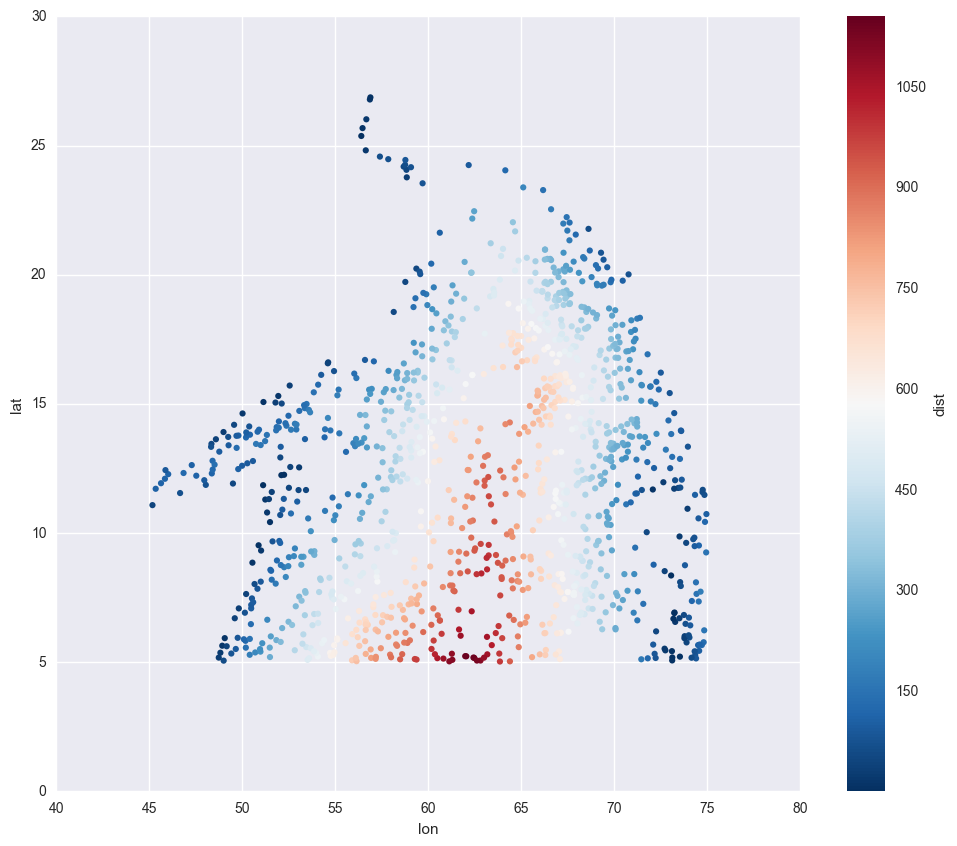


 ******* weekly plots and spatial plots on the rate of change of log-scale chlor-a ******* 


 ****** summary of chl_log_e_rate ****** 
 count    977.000000
mean      -0.002809
std        0.065622
min       -0.427441
25%       -0.022244
50%       -0.002054
75%        0.018081
max        0.290630
Name: chl_log_e_rate, dtype: float64


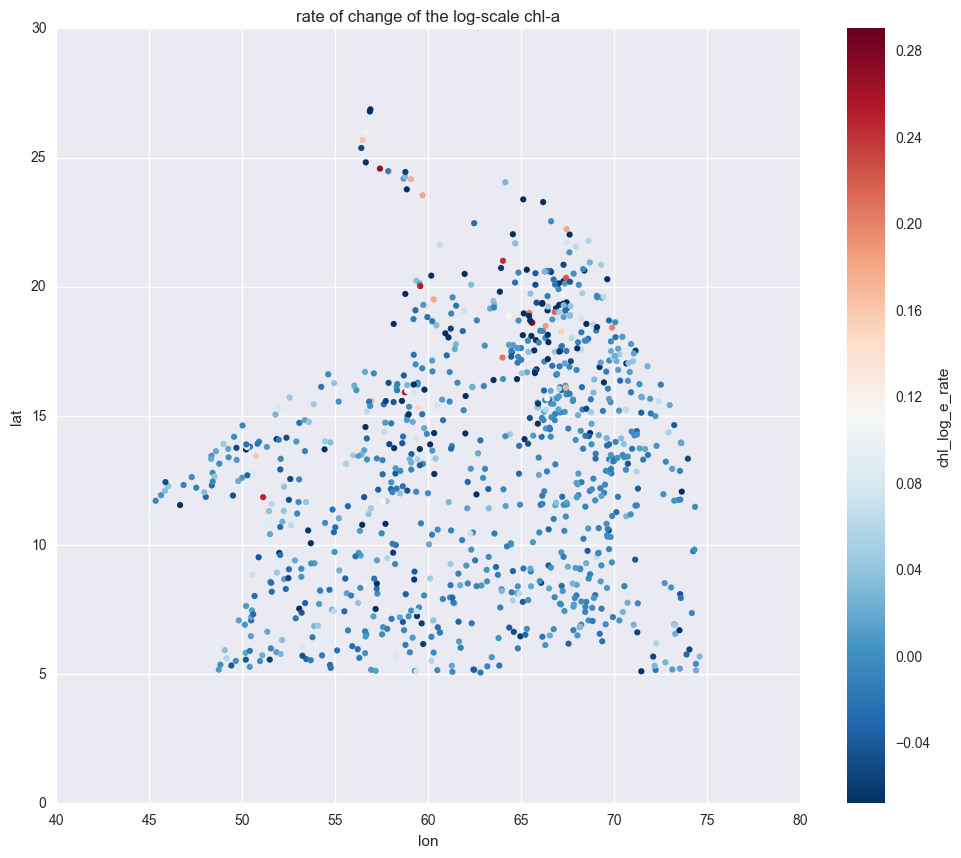


 ****** histogram of chl_log_e_rate ****** 
 count    977.000000
mean      -0.002809
std        0.065622
min       -0.427441
25%       -0.022244
50%       -0.002054
75%        0.018081
max        0.290630
Name: chl_log_e_rate, dtype: float64



 ****** histogram of standardized chl_log_e_rate ****** 
 count    9.770000e+02
mean     2.945212e-17
std      1.000000e+00
min     -6.470881e+00
25%     -2.961703e-01
50%      1.150872e-02
75%      3.183368e-01
max      4.471654e+00
Name: chl_log_e_rate, dtype: float64


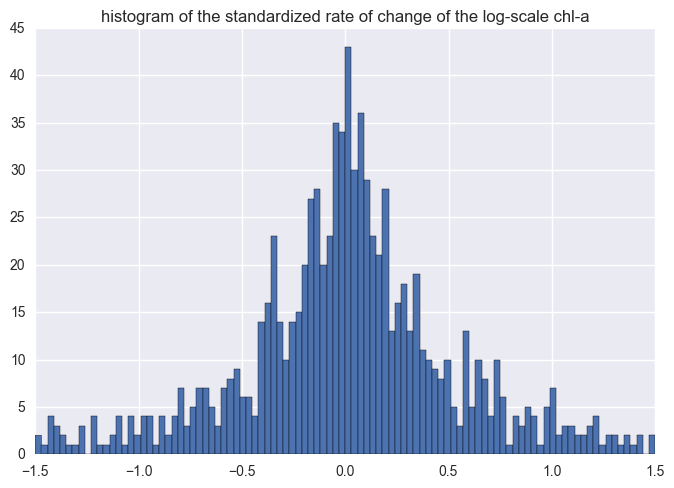


 check check check 
         time     id         ve   var_lon       temp        spd        vn  \
0 2002-11-07   7574        NaN       NaN        NaN        NaN       NaN   
1 2002-11-07  10206  -2.217083  0.001535        NaN   5.446583  2.990778   
2 2002-11-07  10208        NaN       NaN        NaN        NaN       NaN   
3 2002-11-07  11089 -16.412472  0.000123  28.829472  17.995028 -3.991722   
4 2002-11-07  15703        NaN       NaN        NaN        NaN       NaN   

       var_tmp        lat        lon     ...      chlor_a_log_e  chl_rate  \
0          NaN        NaN        NaN     ...                NaN       NaN   
1  1000.000000  11.126222  67.132000     ...          -2.033844 -0.000317   
2          NaN        NaN        NaN     ...                NaN       NaN   
3     0.003812  14.279667  64.391056     ...          -1.641103  0.007509   
4          NaN        NaN        NaN     ...                NaN       NaN   

   chl_log_e_rate  chl_rate_stand  chl_log_e_rate_stand  c

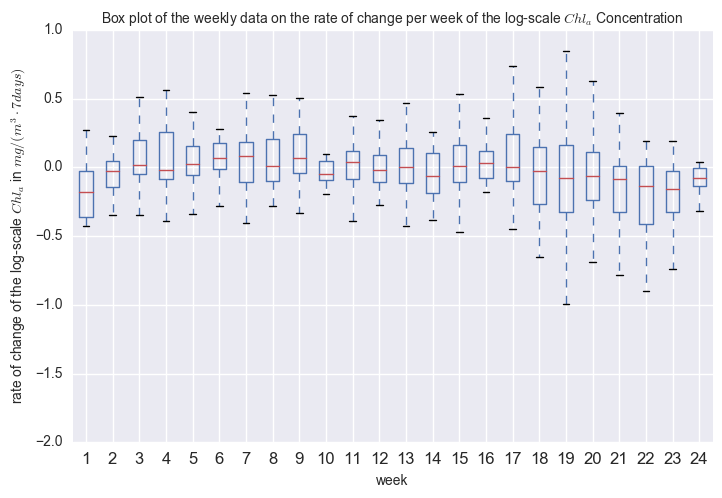


 ****** weekly plot of chl_rate_week ****** 



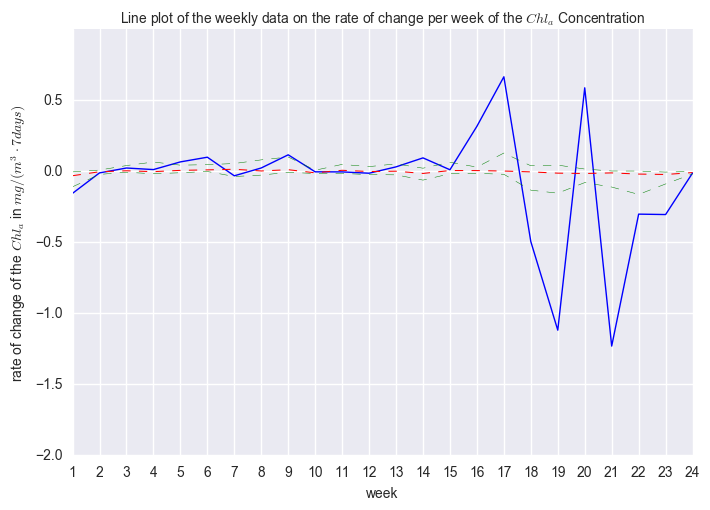

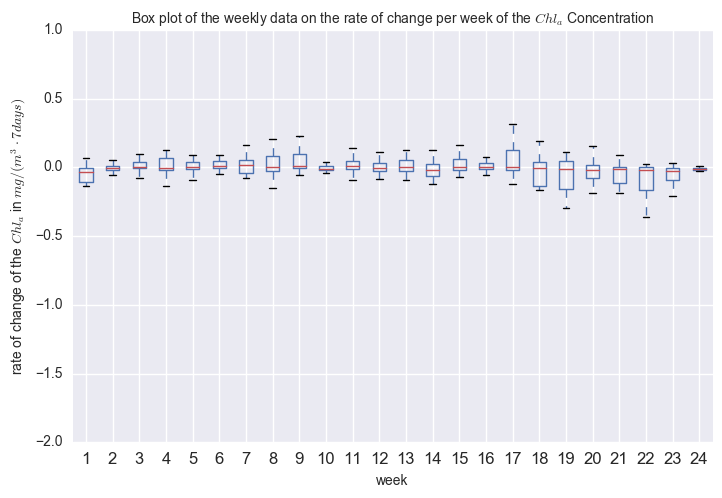


 ****** weekly plot of nondimensionalized daily chl_log_e_rate ****** 



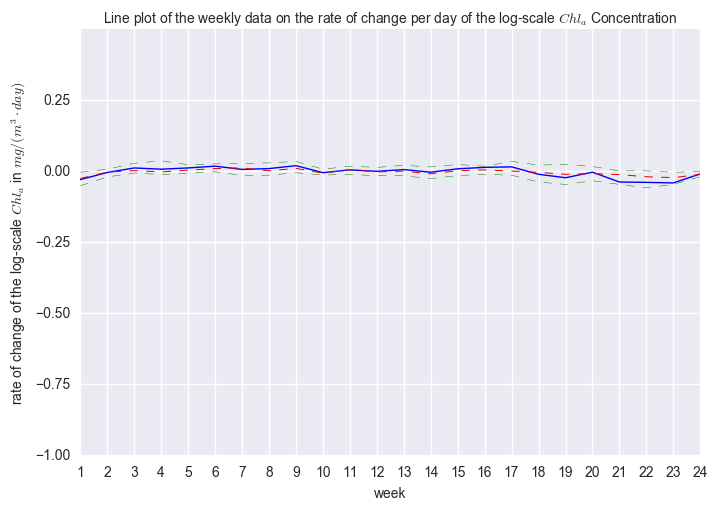

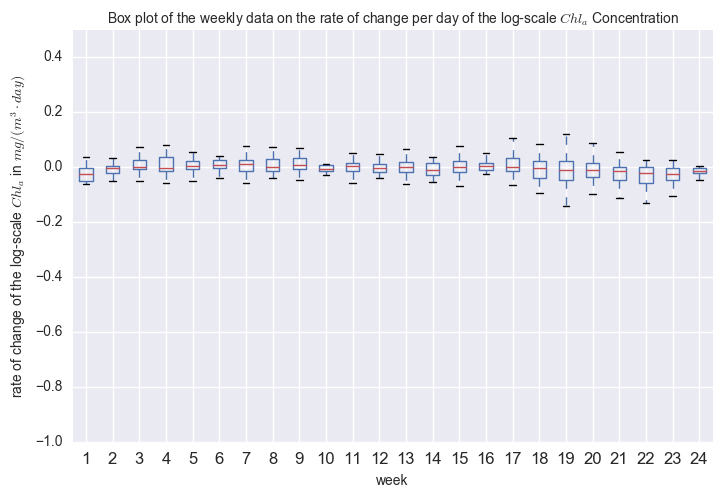


 ****** weekly plot of nondimensionalized daily chl_rate ****** 



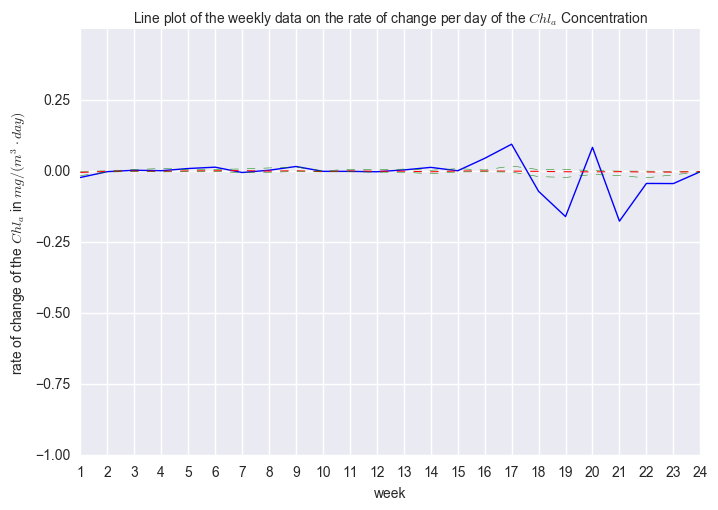

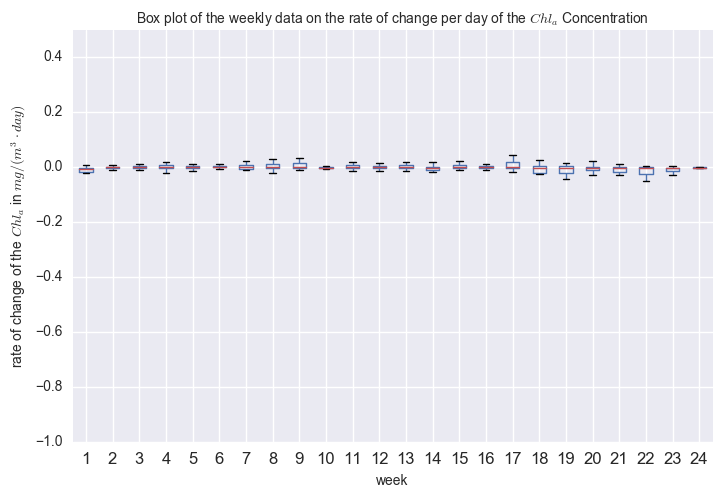


 ****** weekly plot of standardized nondimensionalized-daily chl_log_e_rate ****** 



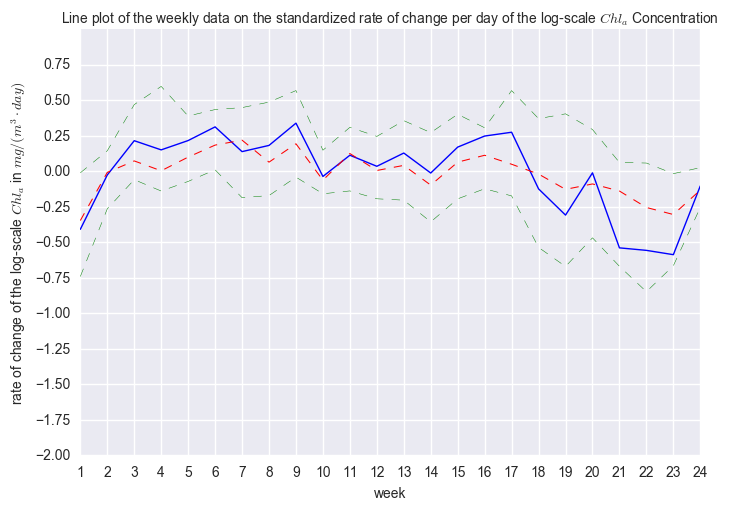

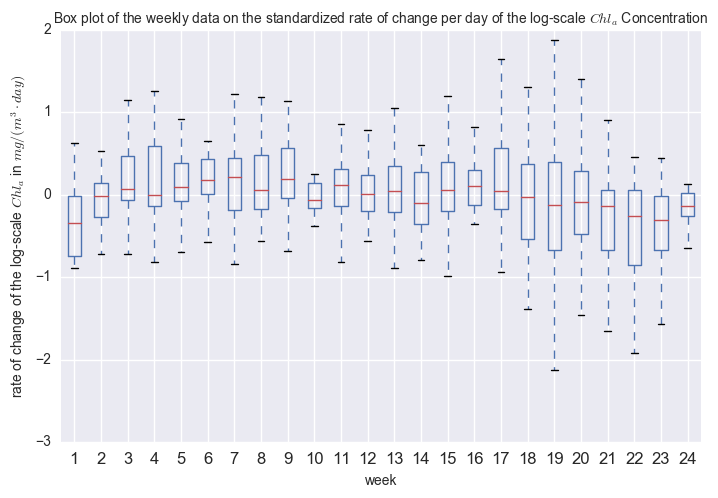


 ****** weekly plot of standardized nondimensionalized-daily chl_rate ****** 



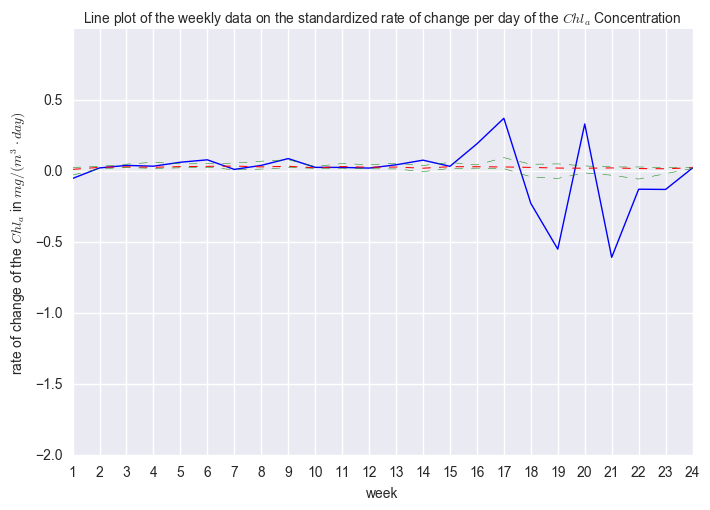

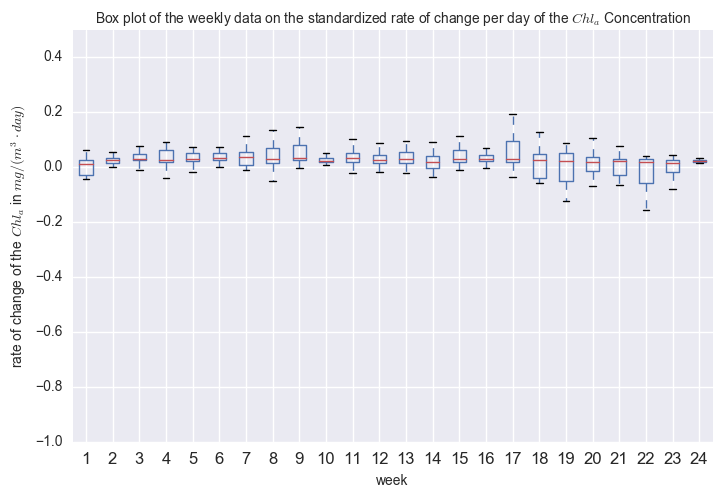


 ****** spatial plot of standardized nondimensionalized-daily chl_rate ****** 



 summary of the Chl_rate 
 count    148.000000
mean       0.002602
std        0.251724
min       -1.930721
25%       -0.023241
50%       -0.002065
75%        0.030507
max        2.154222
Name: chl_rate_week, dtype: float64


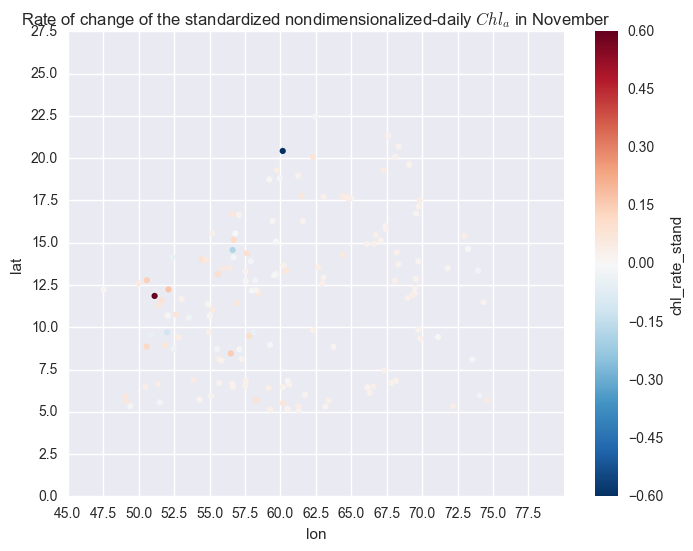



 summary of the Chl_rate 
 count    164.000000
mean       0.032383
std        0.356587
min       -2.385148
25%       -0.014000
50%        0.009070
75%        0.055035
max        2.483033
Name: chl_rate_week, dtype: float64


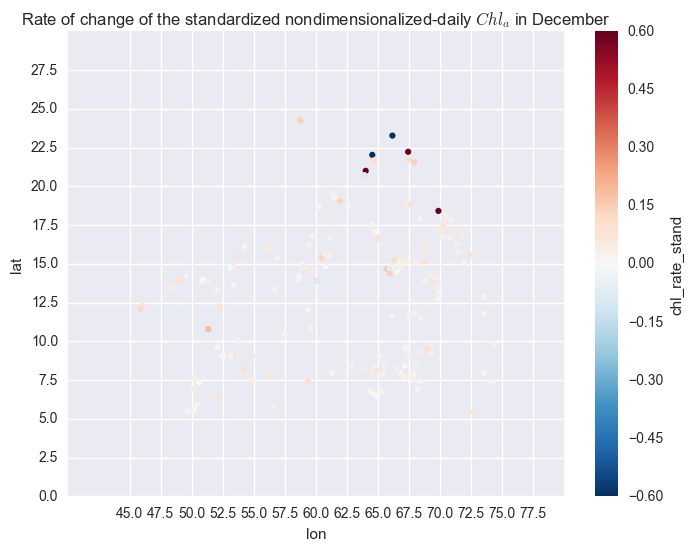



 summary of the Chl_rate 
 count    176.000000
mean       0.054309
std        0.479108
min       -1.350632
25%       -0.026322
50%       -0.000114
75%        0.046779
max        4.940321
Name: chl_rate_week, dtype: float64


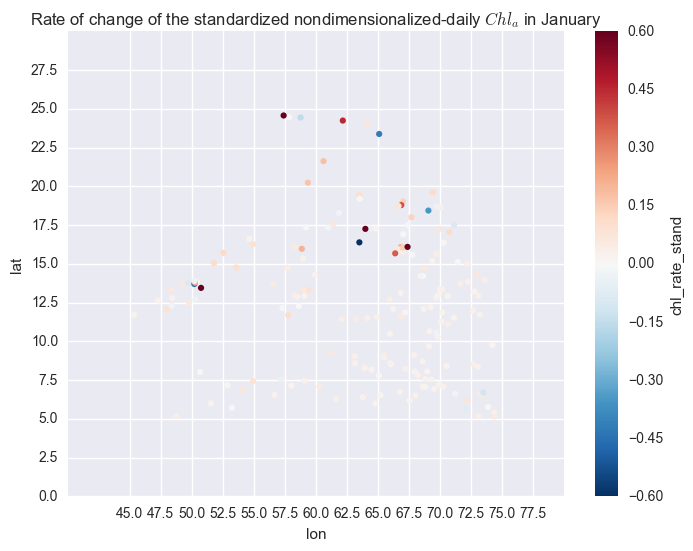



 summary of the Chl_rate 
 count    182.000000
mean      -0.122501
std        3.486971
min      -29.163268
25%       -0.035627
50%       -0.000720
75%        0.039729
max       23.748404
Name: chl_rate_week, dtype: float64


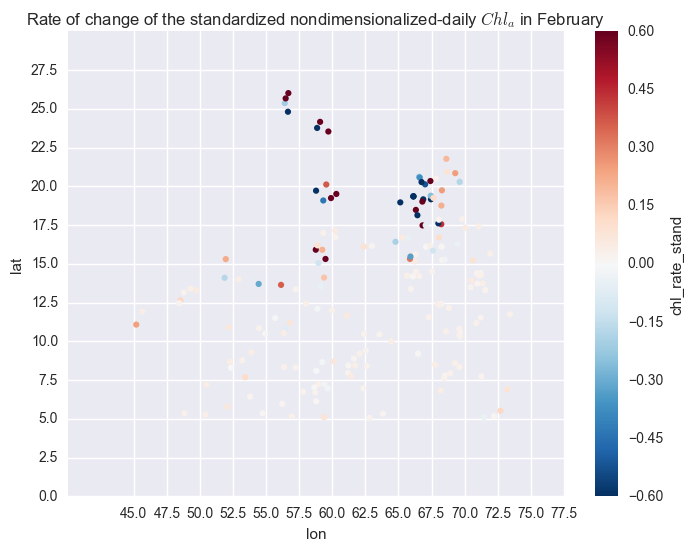



 summary of the Chl_rate 
 count    238.000000
mean      -0.210245
std        2.397038
min      -17.498772
25%       -0.083777
50%       -0.013816
75%        0.002982
max       16.932355
Name: chl_rate_week, dtype: float64


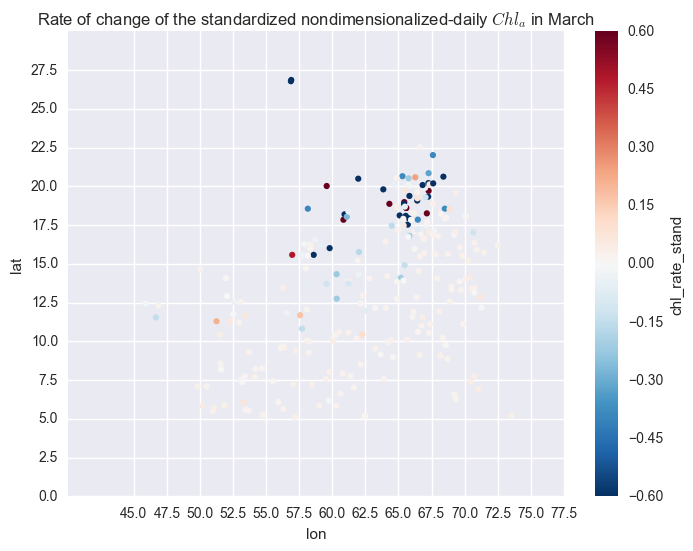


 ******* output data ******* 



NameError: name 'combined_dfRate_interpolate' is not defined

In [211]:
from tools import chl_rates  # del(chl_rates)
import importlib
importlib.reload(chl_rates)
importlib.reload(interpolate)
from tools import distance
importlib.reload(distance)

###### refactorization
# -- chl_rates()  done
# -- spatial_plot_histogram() done
# -- distance_to_coast() done
# -- validation() done
# -- plot the weekly trends()
# -- output_csv()

print("\n ******* The Multilinear Interpolation Approach ******* \n" )
floatsDF_9DRate_interpolate = chl_rates.add_chl_rates(floatsDFAll_9Dtimeorder, result_out4)

print("\n ******* Visualization on chl_rate and chl_log_e_rate ******* \n" )
chl_rates.spatial_hist_plots_chl_rate(floatsDF_9DRate_interpolate)

print("\n ******* Reduce the Dataset to 'Nov-01 to Mar-31' ******* \n" )
floatsDF_9DRate_NovMar = chl_rates.reduce_to_NovMar(floatsDF_9DRate_interpolate)

print("\n ******* Nondimensionalize chl_rate and chl_log_e_rate ******* \n" )
floatsDF_9DRate_NonDim_interpolate = chl_rates.nondimensionalize_chl_rate(floatsDF_9DRate_NovMar, freq)
'''
# check #
aaa = floatsDF_9DRate_NonDim_interpolate
aaa.sort_values(['id','time']).dropna()      
print( (0.293062 - 0.804146)/9 )  # -0.056787 
print( (-1.227370- (-0.217974) )/9 )  # -0.112155 
'''


print("\n **** Adding the 'rotated week no.'; Nov-1 is week no.1 **** \n")
floatsDF_9DRate_weekcol_interpolate = chl_rates.add_week(floatsDF_9DRate_NonDim_interpolate) 

print("\n ******* Distance to coast added ******* \n")
print("\n ******* The Multilinear Interpolation Approach ******* \n" )
row_case_dist = pd.DataFrame(data={'time':list(floatsDF_9DRate_weekcol_interpolate.time), 
                                   'lon':list(floatsDF_9DRate_weekcol_interpolate.lon), 
                                   'lat':list(floatsDF_9DRate_weekcol_interpolate.lat), 
                                   'id':list(floatsDF_9DRate_weekcol_interpolate.id) } )
# process to drop nan in any of the columns [id], [lat], [lon], [time]
row_case_dist = row_case_dist.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
# print('\n after dropping nan \n', row_case_dist)
result_dist = interpolate.sel_points_multilinear_dist_lat_lon(row_case_dist, dims='points', col_name='dist') # interpolation

print("\n ******* Adding the 'distance to coast' ******* \n")
floatsDF_9Ddistance_interpolate = distance.add_distance_to_coast(floatsDF_9DRate_weekcol_interpolate,result_dist)

print("\n ******* Visualization on 'distance to coast' ******* \n" )
distance.spatial_plots_distance(floatsDF_9Ddistance_interpolate)

print("\n ******* weekly plots and spatial plots on various rates of chl-a and log-scale chl-a ******* \n")
chl_rates.spatial_plots_chl_rate_weekly(floatsDF_9Ddistance_interpolate)




print("\n ******* output data ******* \n" )
df_list = []
for i in range(2002,2017):
    tmpyear = combined_dfRate_interpolate[ (combined_dfRate_interpolate.time >= (str(i)+ '-11-01') )  & (combined_dfRate_interpolate.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    df_list.append(tmpyear)
    
df_tmp = pd.concat(df_list)
print("all the data count during 'Nov-01 to Mar-31' is ", df_tmp.chl_rate.dropna().shape) # (977,)>>> (692,)
df_chl_out_interpolate_9D_modisa = df_tmp[~df_tmp.chl_rate.isnull()] # only keep the non-nan values
#list(df_chl_out_interpolate_XD_modisa.groupby(['id']))   # can see the continuity pattern of the Lagarangian difference for each float id

# output to a csv or hdf file
print(df_chl_out_interpolate_9D_modisa.head())

df_chl_out_interpolate_9D_modisa.index.name = 'index'  # make it specific for the index name
# CSV CSV CSV CSV with specfic index
df_chl_out_interpolate_9D_modisa.to_csv('df_chl_out_interpolate_9D_modisa.csv', sep=',', index_label = 'index')
# load CSV output
test = pd.read_csv('df_chl_out_interpolate_9D_modisa.csv', index_col='index')
print('\n \n ****** the two dataset shoud be the same before and after generating output******\n \n')
print(test.head())




# task 5: rerun the full scripts
# task 6: propagate the changes to other notebooks



 ******* weekly plots and spatial plots on the rate of change of log-scale chlor-a ******* 


 ****** summary of chl_log_e_rate ****** 
 count    977.000000
mean      -0.002809
std        0.065622
min       -0.427441
25%       -0.022244
50%       -0.002054
75%        0.018081
max        0.290630
Name: chl_log_e_rate, dtype: float64


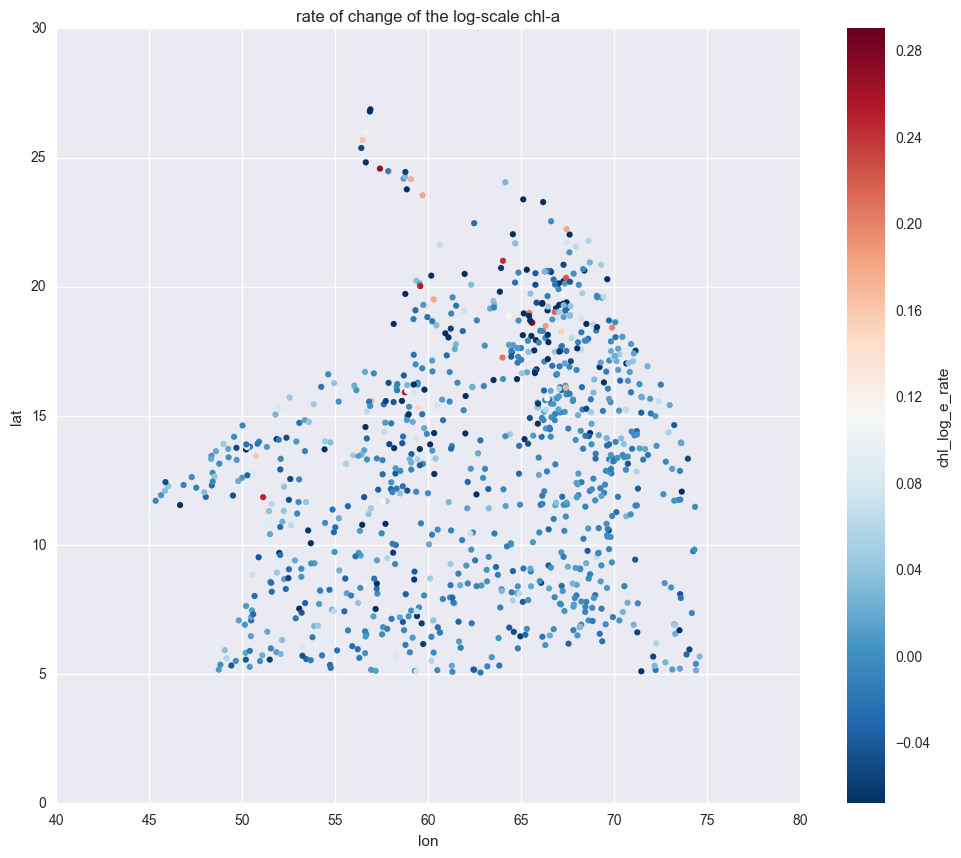


 ****** histogram of chl_log_e_rate ****** 
 count    977.000000
mean      -0.002809
std        0.065622
min       -0.427441
25%       -0.022244
50%       -0.002054
75%        0.018081
max        0.290630
Name: chl_log_e_rate, dtype: float64


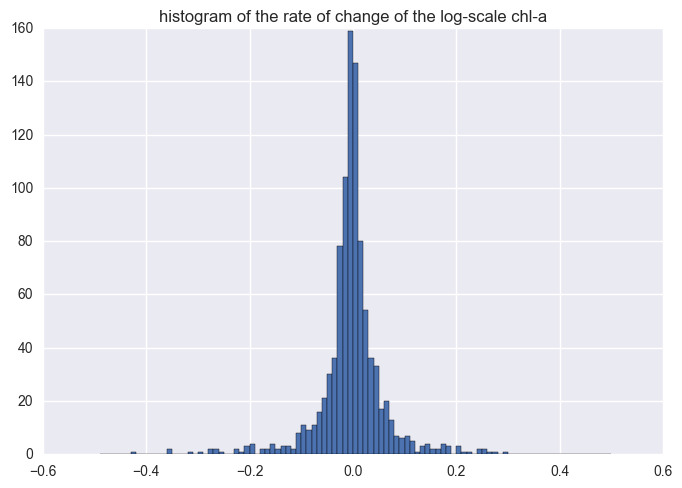


 ****** histogram of standardized chl_log_e_rate ****** 
 count    9.770000e+02
mean     2.945212e-17
std      1.000000e+00
min     -6.470881e+00
25%     -2.961703e-01
50%      1.150872e-02
75%      3.183368e-01
max      4.471654e+00
Name: chl_log_e_rate, dtype: float64


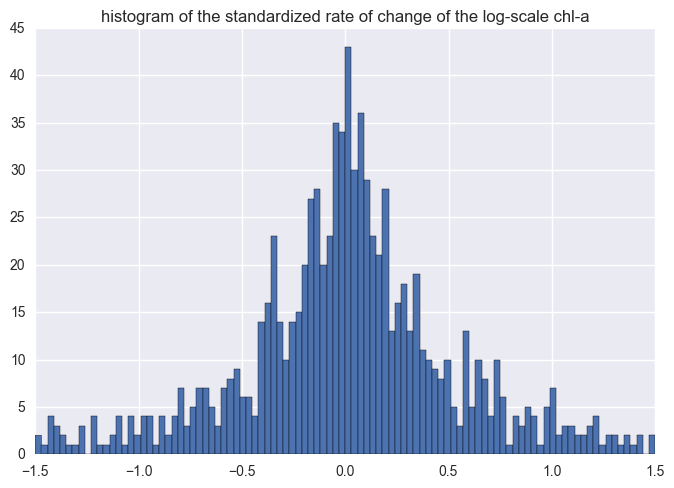


 check check check 
         time     id         ve   var_lon       temp        spd        vn  \
0 2002-11-07   7574        NaN       NaN        NaN        NaN       NaN   
1 2002-11-07  10206  -2.217083  0.001535        NaN   5.446583  2.990778   
2 2002-11-07  10208        NaN       NaN        NaN        NaN       NaN   
3 2002-11-07  11089 -16.412472  0.000123  28.829472  17.995028 -3.991722   
4 2002-11-07  15703        NaN       NaN        NaN        NaN       NaN   

       var_tmp        lat        lon     ...      chlor_a_log_e  chl_rate  \
0          NaN        NaN        NaN     ...                NaN       NaN   
1  1000.000000  11.126222  67.132000     ...          -2.033844 -0.000317   
2          NaN        NaN        NaN     ...                NaN       NaN   
3     0.003812  14.279667  64.391056     ...          -1.641103  0.007509   
4          NaN        NaN        NaN     ...                NaN       NaN   

   chl_log_e_rate  chl_rate_stand  chl_log_e_rate_stand  c

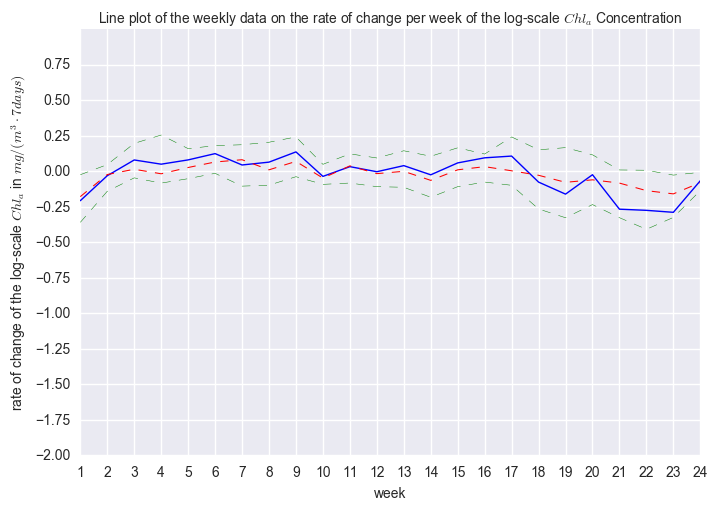

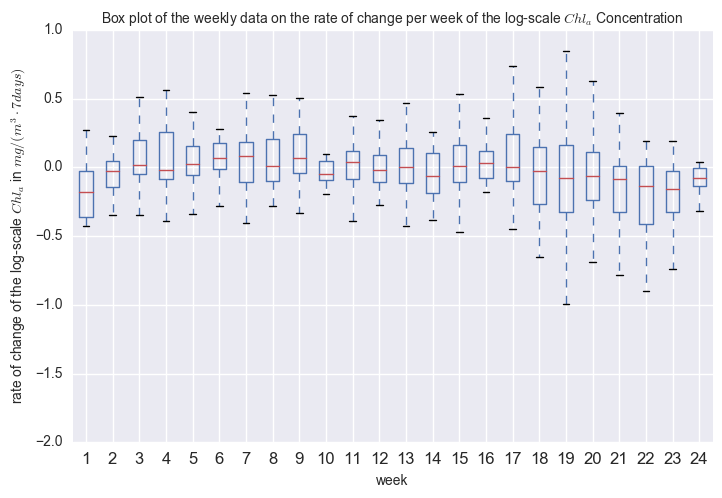


 ****** weekly plot of chl_rate_week ****** 



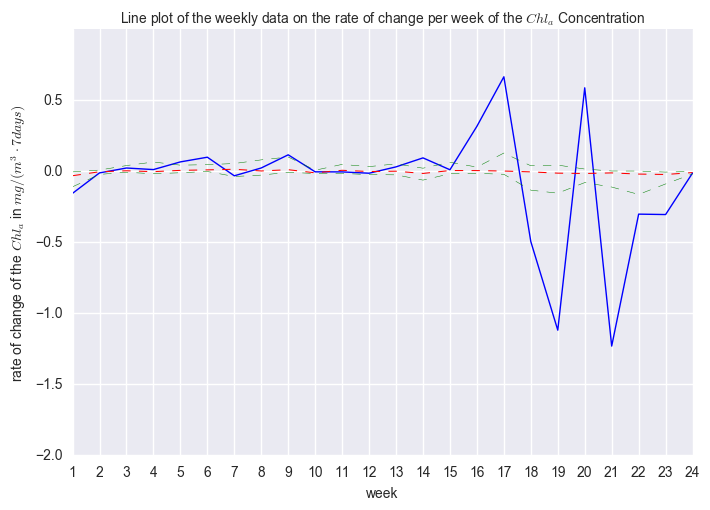

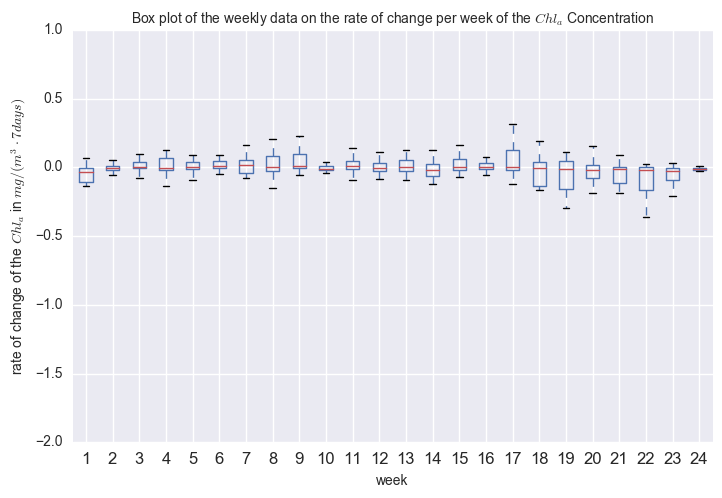


 ****** weekly plot of nondimensionalized daily chl_log_e_rate ****** 



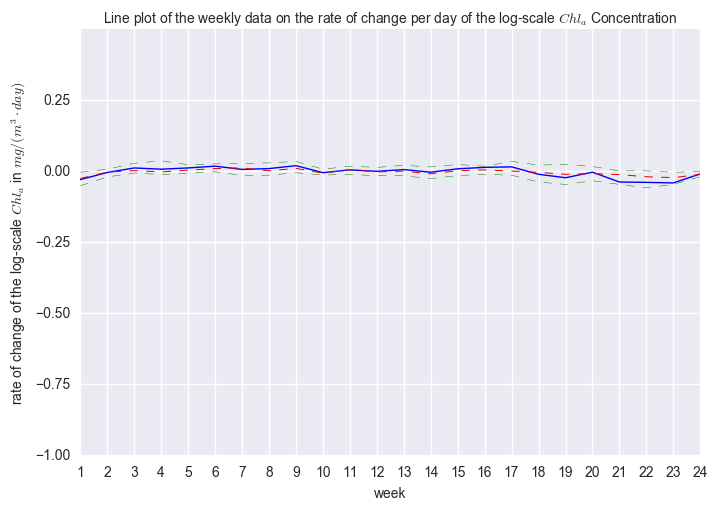

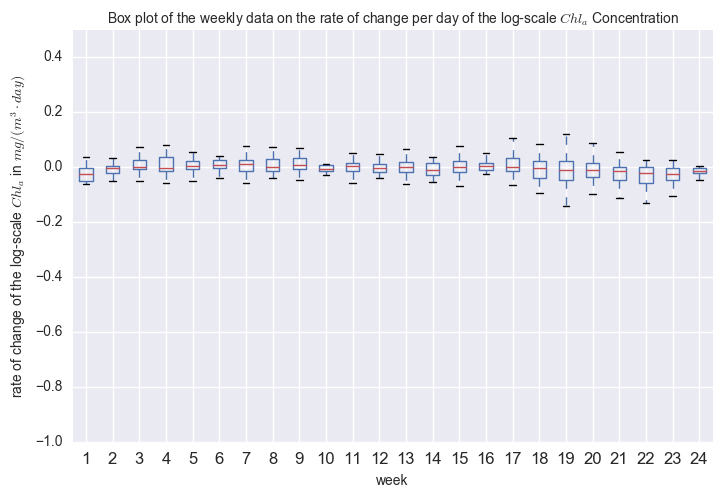


 ****** weekly plot of nondimensionalized daily chl_rate ****** 



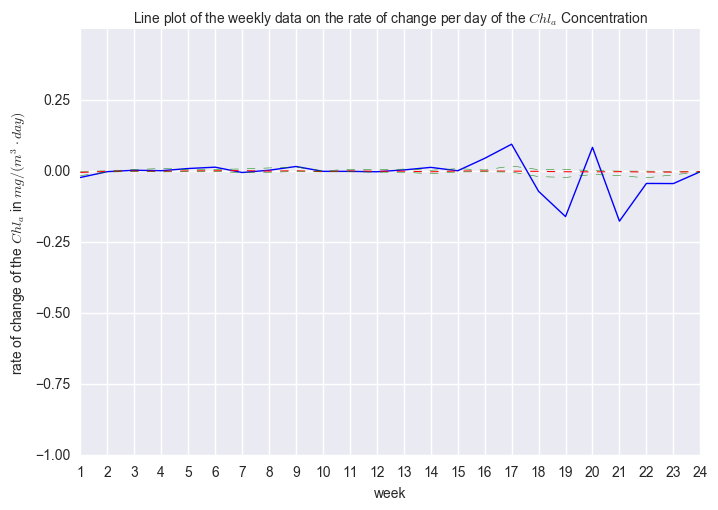

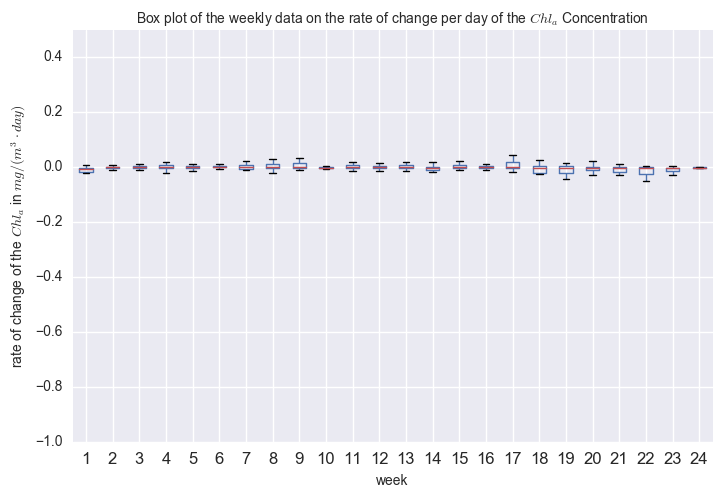


 ****** weekly plot of standardized nondimensionalized-daily chl_log_e_rate ****** 



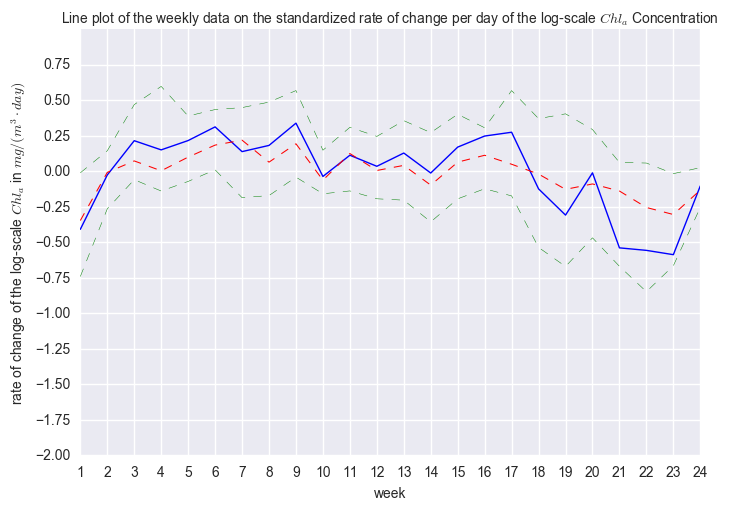

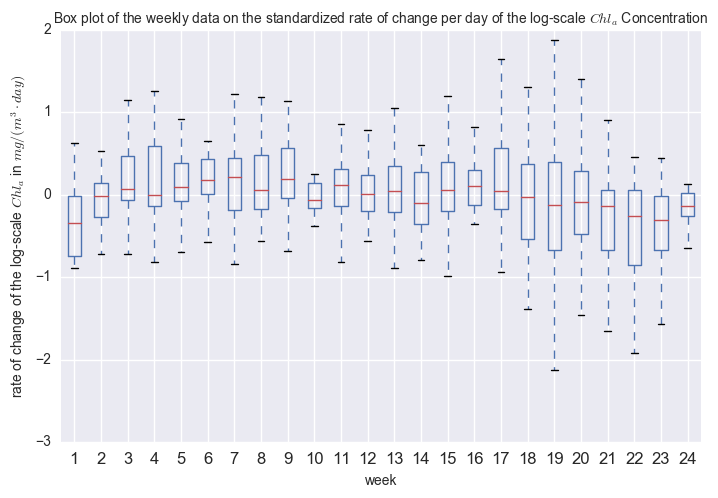


 ****** weekly plot of standardized nondimensionalized-daily chl_rate ****** 



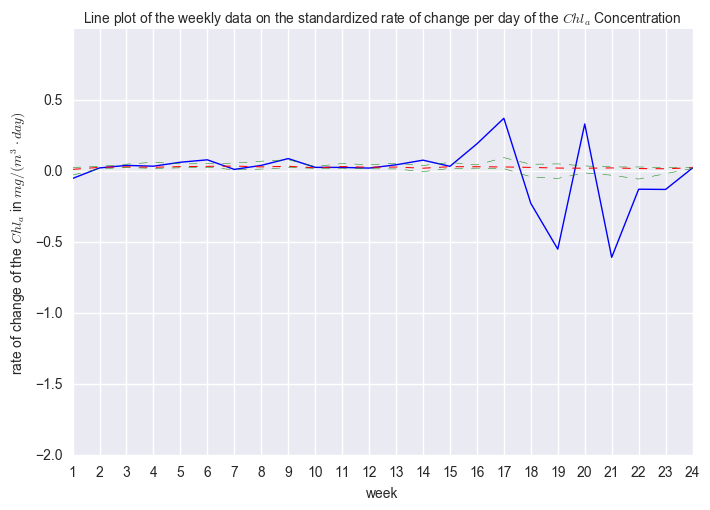

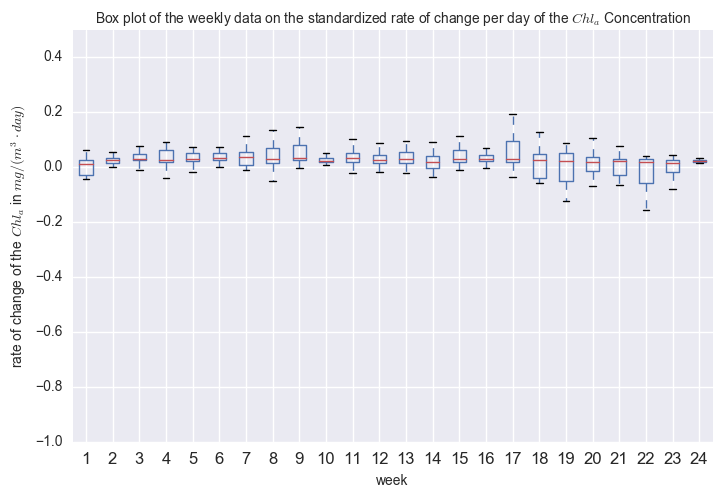


 ****** spatial plot of standardized nondimensionalized-daily chl_rate ****** 



 summary of the Chl_rate 
 count    148.000000
mean       0.002602
std        0.251724
min       -1.930721
25%       -0.023241
50%       -0.002065
75%        0.030507
max        2.154222
Name: chl_rate_week, dtype: float64


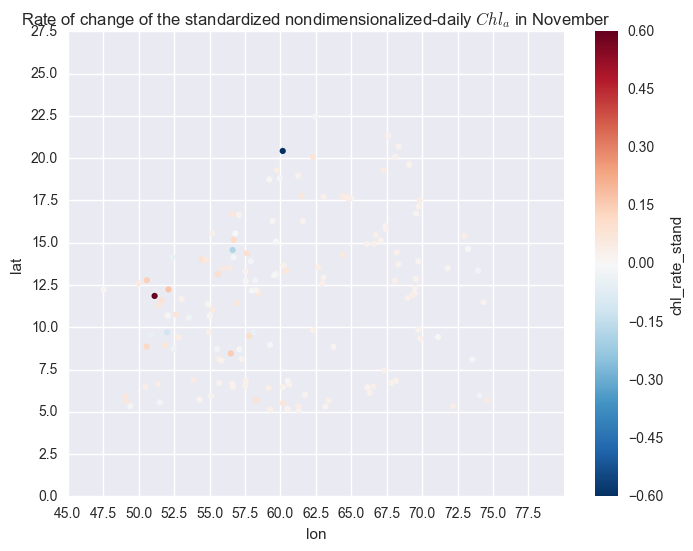



 summary of the Chl_rate 
 count    164.000000
mean       0.032383
std        0.356587
min       -2.385148
25%       -0.014000
50%        0.009070
75%        0.055035
max        2.483033
Name: chl_rate_week, dtype: float64


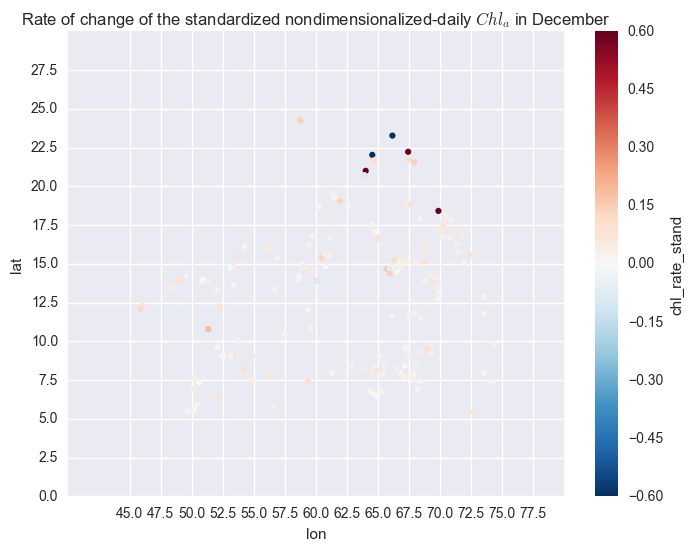



 summary of the Chl_rate 
 count    176.000000
mean       0.054309
std        0.479108
min       -1.350632
25%       -0.026322
50%       -0.000114
75%        0.046779
max        4.940321
Name: chl_rate_week, dtype: float64


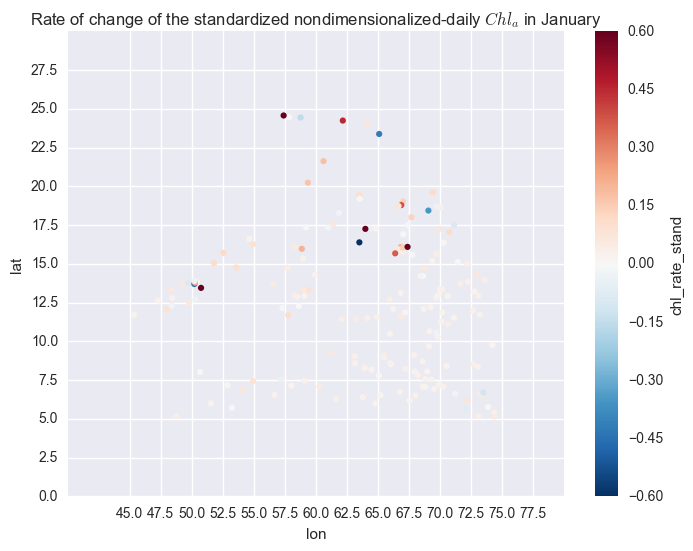



 summary of the Chl_rate 
 count    182.000000
mean      -0.122501
std        3.486971
min      -29.163268
25%       -0.035627
50%       -0.000720
75%        0.039729
max       23.748404
Name: chl_rate_week, dtype: float64


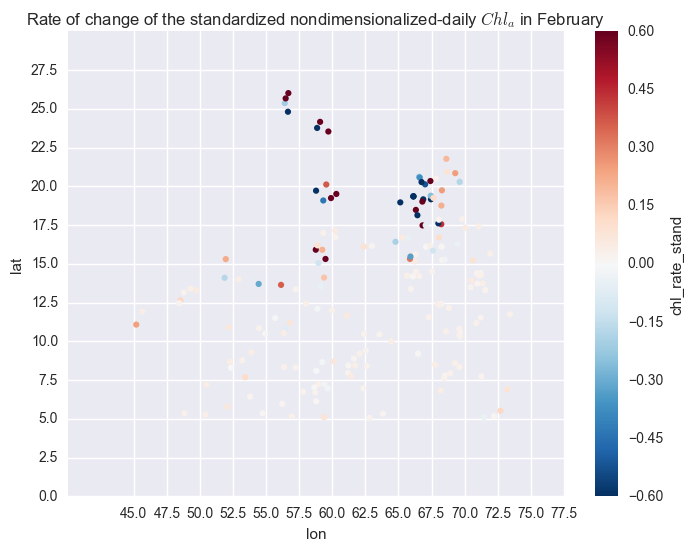



 summary of the Chl_rate 
 count    238.000000
mean      -0.210245
std        2.397038
min      -17.498772
25%       -0.083777
50%       -0.013816
75%        0.002982
max       16.932355
Name: chl_rate_week, dtype: float64


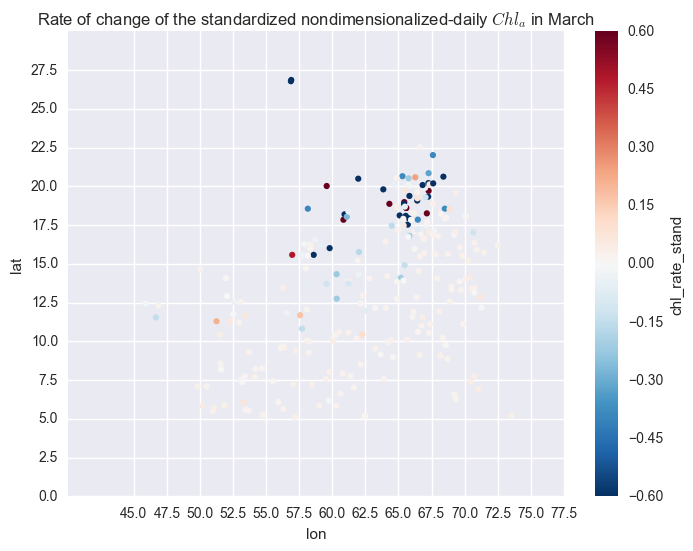

0

In [210]:
import importlib
importlib.reload(chl_rates)
print("\n ******* weekly plots and spatial plots on the rate of change of log-scale chlor-a ******* \n")
chl_rates.spatial_plots_chl_rate_weekly(floatsDF_9Ddistance_interpolate)

In [372]:
#### the original approach using the xarray.dataset.sel_points
# a little test for the api in loops for the dataframe   
# check df.itertuples? it is faster and preserves the data format
'''
chl_ocx=[]
for row in floats_timeorder.itertuples():
    #print(row) # this line should not be executed!!!! takes a long time!!!!!
    #print('row.time = %s, row.id=%d, row.lon=%4.3f, row.lat=%4.3f' % (row.time,row.id,row.lon,row.lat)  )
    tmp=ds_2day.chl_ocx.sel_points(time=[row.time],lon=[row.lon], lat=[row.lat], method='nearest') # interpolation
    chl_ocx.append(tmp)
floats_timeorder['chl_ocx'] = pd.Series(chl_ocx, index=floats_timeorder.index)
chl_ocx[0].to_series
'''

# this one line avoid the list above
# it took a really long time for 2D interpolation, it takes an hour
tmpAll = ds_9day.chlor_a.sel_points(time=list(floatsDFAll_9Dtimeorder.time),lon=list(floatsDFAll_9Dtimeorder.lon), lat=list(floatsDFAll_9Dtimeorder.lat), method='nearest')
#print('the count of nan vaues in tmpAll is',tmpAll.to_series().isnull().sum())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


In [373]:
tmpAll # an array of xarray.DataArray

<xarray.DataArray 'chlor_a' (points: 147112)>
array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
Coordinates:
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
    lon      (points) float64 74.96 66.54 69.88 65.04 69.88 74.96 69.46 ...
    lat      (points) float64 27.96 16.21 13.62 16.04 13.62 27.96 20.04 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...

In [374]:
#print(tmpAll.dropna().shape)
tmpAll.to_series().dropna().shape  # (1631,) good values

(1631,)

In [630]:
(82)+ (2)+(19)+(93)+(69)+(199)+(41)+(70)+(9)+(61)+(0)+(136) +(130) +(66) 

977

after editing the dataframe the nan values in 'chlor_a' is 145481


(1631,)

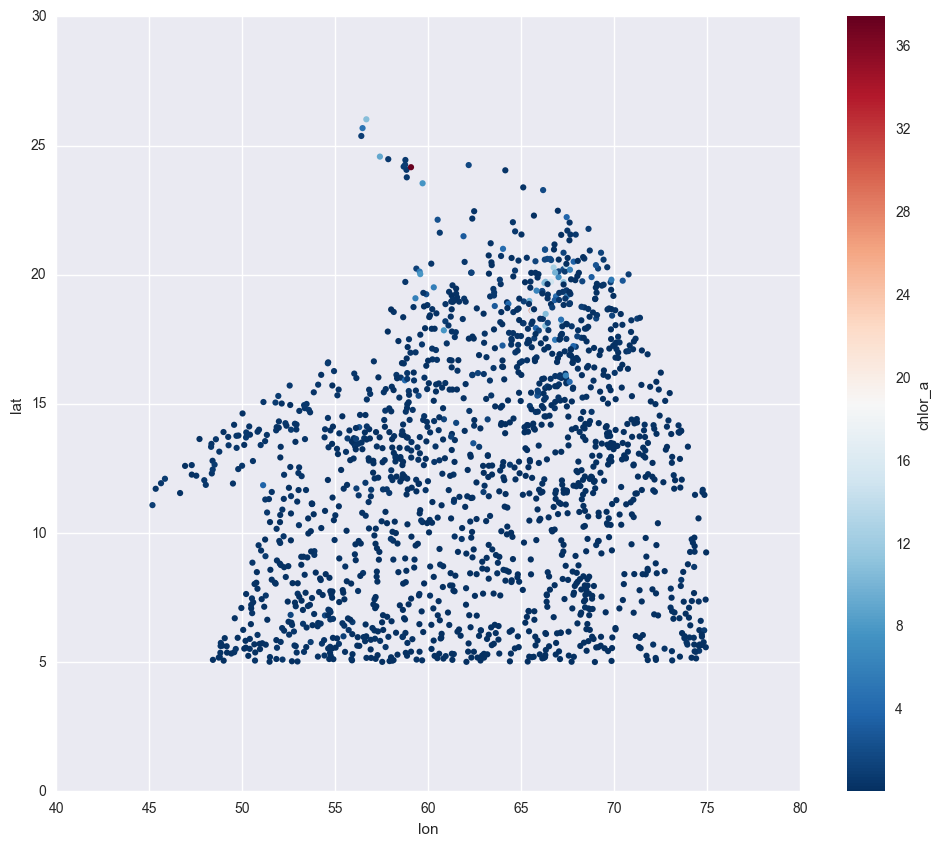

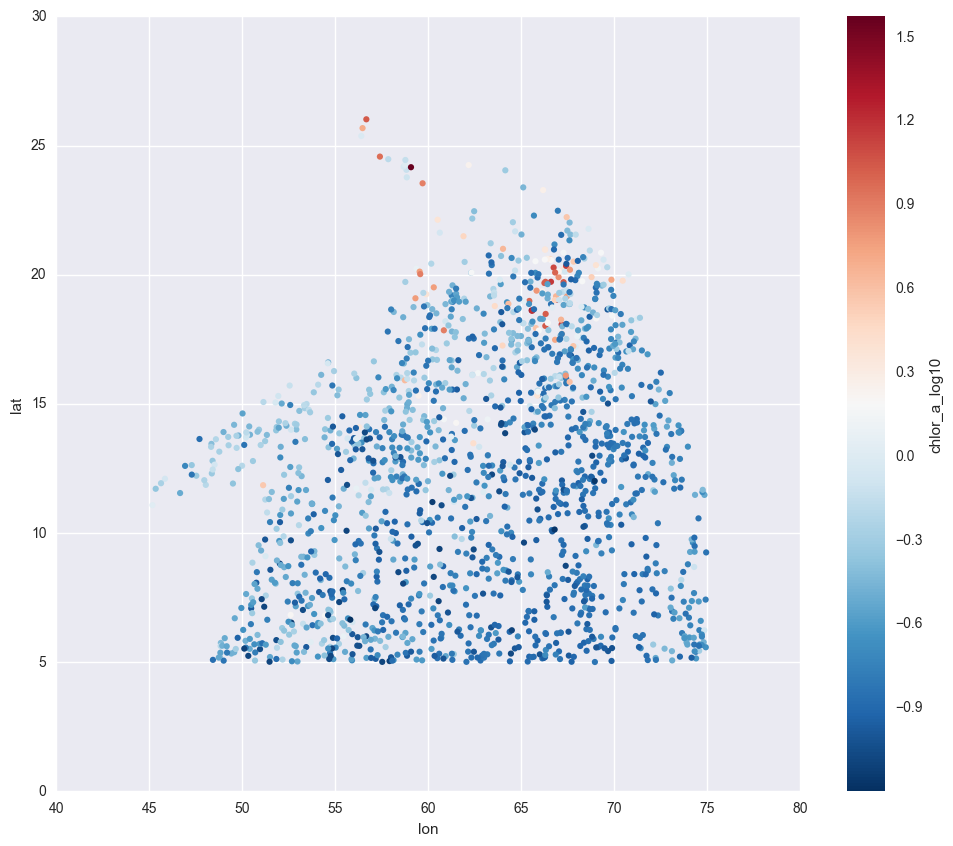

In [375]:
# tmp.to_series() to transfer it from xarray dataset to series
floatsDFAll_9Dtimeorder['chlor_a'] = pd.Series(np.array(tmpAll.to_series()), index=floatsDFAll_9Dtimeorder.index)
print("after editing the dataframe the nan values in 'chlor_a' is", floatsDFAll_9Dtimeorder.chlor_a.isnull().sum() )  # they should be the same values as above

# take a look at the data
floatsDFAll_9Dtimeorder

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_9Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chlor_a', cmap='RdBu_r', edgecolor='none', ax=ax)

def scale(x):
    logged = np.log10(x)
    return logged

#print(floatsAll_timeorder['chlor_a'].apply(scale))
floatsDFAll_9Dtimeorder['chlor_a_log10'] = floatsDFAll_9Dtimeorder['chlor_a'].apply(scale)
floatsDFAll_9Dtimeorder
#print("after the transformation the nan values in 'chlor_a_log10' is", floatsAll_timeorder.chlor_a_log10.isnull().sum() )

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_9Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chlor_a_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
floatsDFAll_9Dtimeorder.chlor_a.dropna().shape  # (1631,)
#floatsDFAll_9Dtimeorder.chlor_a_log10.dropna().shape  # (1631,)

In [376]:
# take the diff of the chlor_a, and this has to be done in xarray
# transfer the dataframe into xarry dataset again
# take the difference
floatsDFAll_9Dtimeorder

id       time   var_lat         vn       temp        lon  \
0           7574 2002-07-04       NaN        NaN        NaN        NaN   
568        10206 2002-07-04  0.001326   0.027056        NaN  66.533639   
1136       10208 2002-07-04  0.000061  -8.270944        NaN  69.914139   
1704       11089 2002-07-04  0.000065 -14.363611  27.796889  65.036972   
2272       15703 2002-07-04  0.000054  -7.037222  28.572750  69.915889   
2840       15707 2002-07-04       NaN        NaN        NaN        NaN   
3408       27069 2002-07-04  0.000056  -1.797889  28.981389  69.445889   
3976       27139 2002-07-04       NaN        NaN        NaN        NaN   
4544       28842 2002-07-04  0.000099  -8.122111  27.620472  60.830556   
5112       34159 2002-07-04  0.000059  16.704556        NaN  59.736889   
5680       34173 2002-07-04       NaN        NaN        NaN        NaN   
6248       34210 2002-07-04  0.000063 -17.727861  26.452806  56.763194   
6816       34211 2002-07-04  0.000055 -14.241500  28.380222  68.565389   
7384       34212 2002-07-04  0.000055   7.009000  28.577889  65.946111   
7952       34223 2002-07-04       NaN        NaN        NaN        NaN   
8520       34310 2002-07-04       NaN        NaN        NaN        NaN   
9088       34311 2002-07-04       NaN        NaN        NaN        NaN   
9656       34312 2002-07-04       NaN        NaN        NaN        NaN   
10224      34314 2002-07-04       NaN        NaN        NaN        NaN   
10792      34315 2002-07-04       NaN        NaN        NaN        NaN   
11360      34374 2002-07-04       NaN        NaN        NaN        NaN   
11928      34708 2002-07-04  0.000057   2.088833  27.291500  60.658278   
12496      34709 2002-07-04  0.000094  47.817000  26.934000  52.974000   
13064      34710 2002-07-04  0.000051  -8.140111  31.149000  50.333750   
13632      34714 2002-07-04  0.000059   4.682833  27.765694  64.694000   
14200      34716 2002-07-04  0.000057   2.213806  28.780944  66.285250   
14768      34718 2002-07-04  0.000055 -33.327528  29.063444  72.973500   
15336      34719 2002-07-04  0.000057 -20.858056  28.959417  71.378167   
15904      34720 2002-07-04  0.000060 -19.437778  28.664167  69.482472   
16472      34721 2002-07-04  0.000060 -10.328972  27.908083  65.552333   
...          ...        ...       ...        ...        ...        ...   
130639   3098682 2016-06-23       NaN        NaN        NaN        NaN   
131207  60073460 2016-06-23       NaN        NaN        NaN        NaN   
131775  60074440 2016-06-23       NaN        NaN        NaN        NaN   
132343  60077450 2016-06-23       NaN        NaN        NaN        NaN   
132911  60150420 2016-06-23       NaN        NaN        NaN        NaN   
133479  60454500 2016-06-23       NaN        NaN        NaN        NaN   
134047  60656200 2016-06-23       NaN        NaN        NaN        NaN   
134615  60657200 2016-06-23       NaN        NaN        NaN        NaN   
135183  60658190 2016-06-23       NaN        NaN        NaN        NaN   
135751  60659110 2016-06-23       NaN        NaN        NaN        NaN   
136319  60659120 2016-06-23       NaN        NaN        NaN        NaN   
136887  60659190 2016-06-23       NaN        NaN        NaN        NaN   
137455  60659200 2016-06-23       NaN        NaN        NaN        NaN   
138023  60940960 2016-06-23       NaN        NaN        NaN        NaN   
138591  60940970 2016-06-23       NaN        NaN        NaN        NaN   
139159  60941960 2016-06-23       NaN        NaN        NaN        NaN   
139727  60941970 2016-06-23       NaN        NaN        NaN        NaN   
140295  60942960 2016-06-23       NaN        NaN        NaN        NaN   
140863  60942970 2016-06-23       NaN        NaN        NaN        NaN   
141431  60943960 2016-06-23       NaN        NaN        NaN        NaN   
141999  60943970 2016-06-23       NaN        NaN        NaN        NaN   
142567  60944960 2016-06-23       NaN        NaN        NaN        NaN   
143135  60944970 2

In [377]:
# unstack() will provide a 2d dataframe
# reset_index() will reset all the index as columns

check the sum of the chlor_a before the merge -64.3533472159612
check the sum of the chlor_a after the merge -64.3533472159612


(417,)

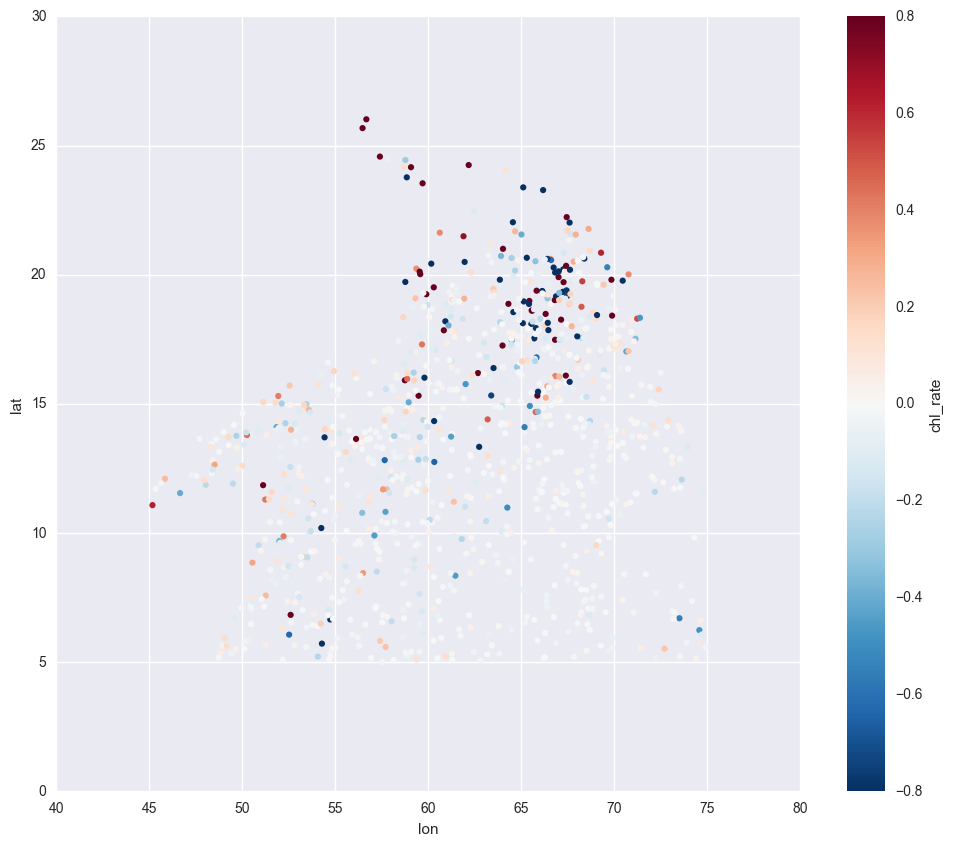

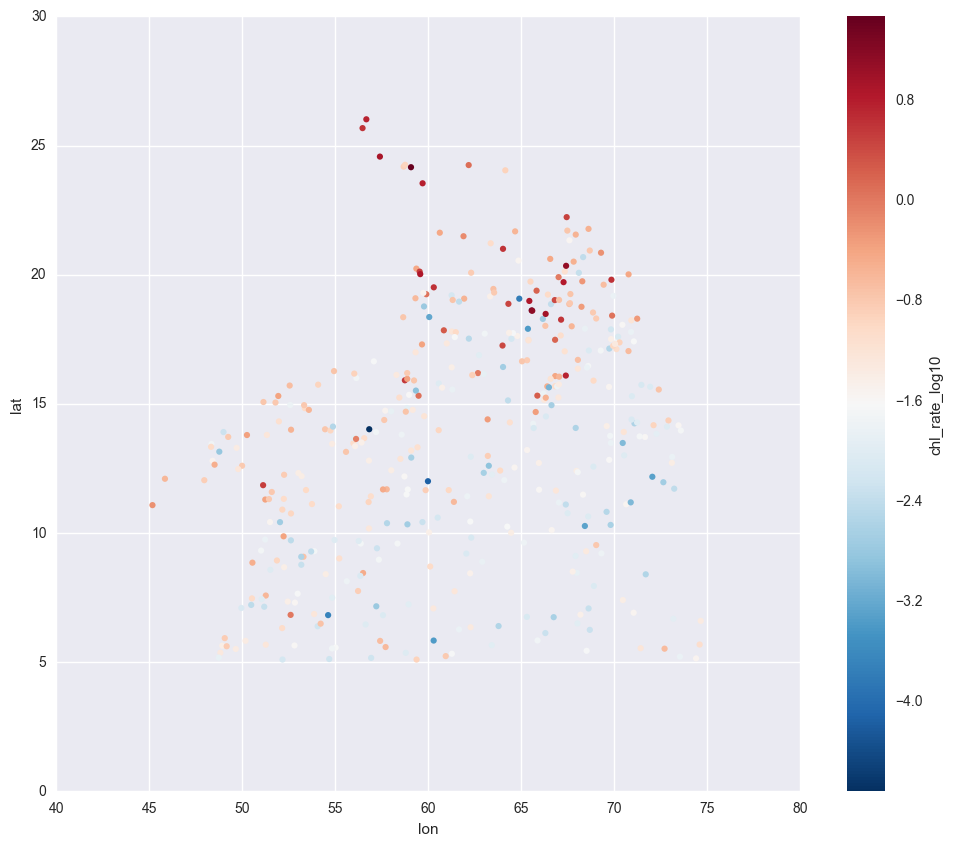

In [378]:
# prepare the data in dataset and about to take the diff
tmp = xr.Dataset.from_dataframe(floatsDFAll_9Dtimeorder.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
# take the diff on the chlor_a
chlor_a_rate = tmp.diff(dim='time',n=1).chlor_a.to_series().reset_index()
# make the column to a proper name
chlor_a_rate.rename(columns={'chlor_a':'chl_rate'}, inplace='True')
chlor_a_rate


# merge the two dataframes {floatsDFAll_XDtimeorder; chlor_a_rate} into one dataframe based on the index {id, time} and use the left method
floatsDFAllRate_9Dtimeorder=pd.merge(floatsDFAll_9Dtimeorder,chlor_a_rate, on=['time','id'], how = 'left')
floatsDFAllRate_9Dtimeorder

# check 
print('check the sum of the chlor_a before the merge', chlor_a_rate.chl_rate.sum())
print('check the sum of the chlor_a after the merge',floatsDFAllRate_9Dtimeorder.chl_rate.sum())


# visualize the chlorophyll rate, it is *better* to visualize at this scale
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_9Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.8, vmax=0.8, edgecolor='none', ax=ax)

# visualize the chlorophyll rate on the log scale
floatsDFAllRate_9Dtimeorder['chl_rate_log10'] = floatsDFAllRate_9Dtimeorder['chl_rate'].apply(scale)
floatsDFAllRate_9Dtimeorder
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_9Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
#floatsDFAllRate_9Dtimeorder.chl_rate.dropna().shape   # (1008,) data points
floatsDFAllRate_9Dtimeorder.chl_rate_log10.dropna().shape   # (417,)data points..... notice, chl_rate can be negative, so do not take log10

In [49]:
pd.to_datetime(floatsDFAllRate_9Dtimeorder.time)
type(pd.to_datetime(floatsDFAllRate_9Dtimeorder.time))
ts = pd.Series(0, index=pd.to_datetime(floatsDFAllRate_9Dtimeorder.time) ) # creat a target time series for masking purpose

# take the month out
month = ts.index.month 
# month.shape # a check on the shape of the month.
selector = ((11==month) | (12==month) | (1==month) | (2==month) | (3==month) )  
selector
print('shape of the selector', selector.shape)

print('all the data count in [11-01, 03-31]  is', floatsDFAllRate_9Dtimeorder[selector].chl_rate.dropna().shape) # total (672,)
print('all the data count is', floatsDFAllRate_9Dtimeorder.chl_rate.dropna().shape )   # total (1008,)

shape of the selector (147112,)
all the data count in [11-01, 03-31]  is (672,)
all the data count is (1008,)


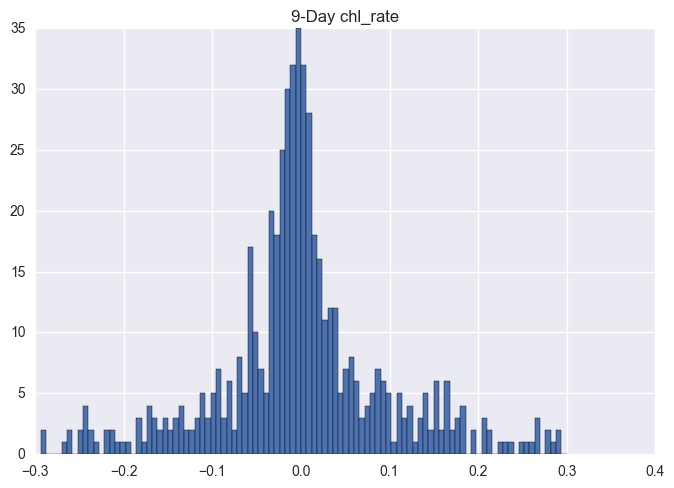

In [50]:
# histogram for non standarized data
axfloat = floatsDFAllRate_9Dtimeorder[selector].chl_rate.dropna().hist(bins=100,range=[-0.3,0.3])
axfloat.set_title('9-Day chl_rate')

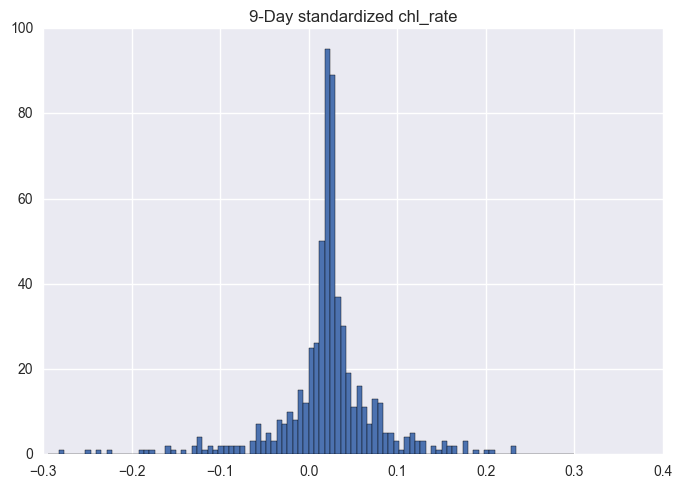

In [51]:
# standarized series
ts = floatsDFAllRate_9Dtimeorder[selector].chl_rate.dropna()
ts_standardized = (ts - ts.mean())/ts.std()
axts = ts_standardized.hist(bins=100,range=[-0.3,0.3])
axts.set_title('9-Day standardized chl_rate')

(47,)
(45,)
(7,)
(38,)
(105,)
(92,)
(140,)
(31,)
(62,)
(16,)
(32,)
(28,)
(198,)
(105,)
(55,)


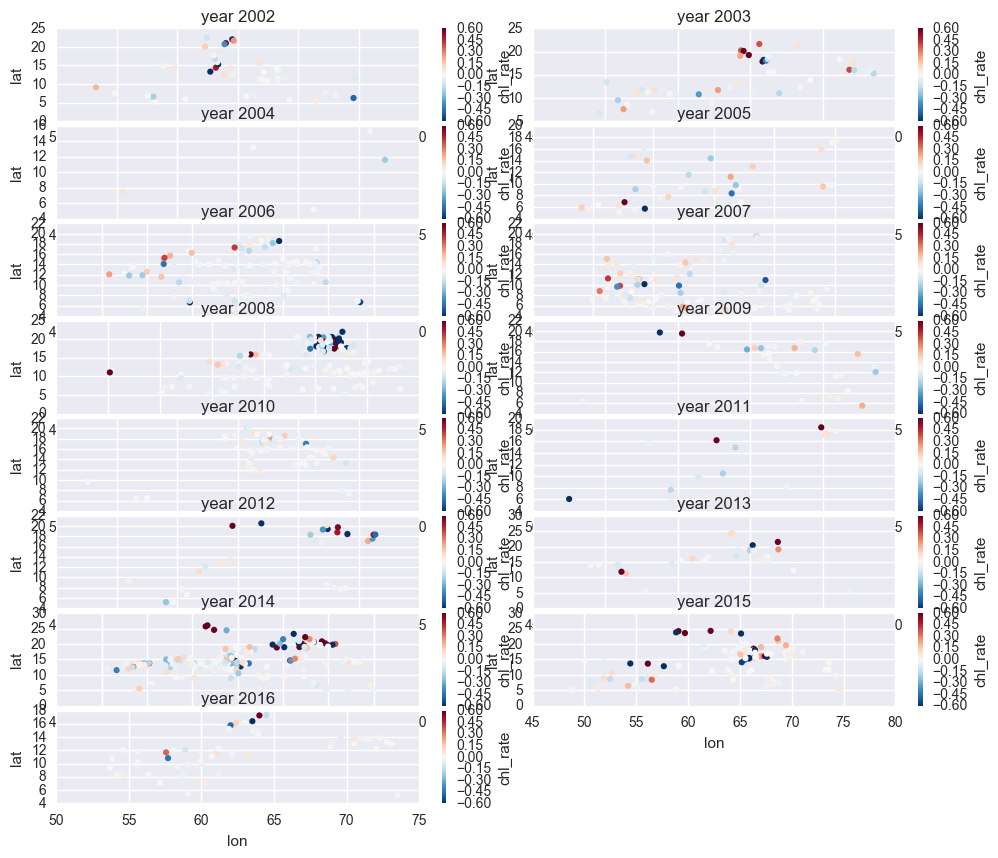

In [52]:
# all the data
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(2002,2017), axes.flat) :
    tmpyear = floatsDFAllRate_9Dtimeorder[ (floatsDFAllRate_9Dtimeorder.time > str(i))  & (floatsDFAllRate_9Dtimeorder.time < str(i+1)) ] # if year i
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)   # total is 1001
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r',vmin=-0.6, vmax=0.6, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)     
    
# remove the extra figure
ax = plt.subplot(8,2,16)
fig.delaxes(ax)

In [53]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(2002,2016), axes.flat) :
    tmpyear = floatsDFAllRate_9Dtimeorder[ (floatsDFAllRate_9Dtimeorder.time >= (str(i)+ '-11-01') )  & (floatsDFAllRate_9Dtimeorder.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)  # the total is 672
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.6, vmax=0.6, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)  

(58,)
(1,)
(9,)
(66,)
(44,)
(129,)
(28,)
(50,)
(5,)
(32,)
(0,)
(106,)
(91,)
(53,)


In [104]:
# let's output the data as a csv or hdf file to disk to save the experiment time

df_list = []
for i in range(2002,2017) :
    tmpyear = floatsDFAllRate_9Dtimeorder[ (floatsDFAllRate_9Dtimeorder.time >= (str(i)+ '-11-01') )  & (floatsDFAllRate_9Dtimeorder.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    df_list.append(tmpyear)
    
df_tmp = pd.concat(df_list)
print('all the data count in [11-01, 03-31]  is ', df_tmp.chl_rate.dropna().shape) # again, the total is (692,)
df_chl_out_9D_modisa = df_tmp[~df_tmp.chl_rate.isnull()] # only keep the non-nan values
#list(df_chl_out_XD.groupby(['id']))   # can see the continuity pattern of the Lagarangian difference for each float id

# output to a csv or hdf file
df_chl_out_9D_modisa.head()

all the data count in [11-01, 03-31]  is  (672,)


id       time       temp   var_lat      var_tmp         ve   var_lon  \
3627  10206 2002-11-07        NaN  0.000494  1000.000000  -2.217083  0.001535   
3629  11089 2002-11-07  28.829472  0.000064     0.003812 -16.412472  0.000123   
3631  15707 2002-11-07        NaN  0.000074  1000.000000 -12.316611  0.000147   
3649  34710 2002-11-07  28.448167  0.000069     0.001857  -2.827667  0.000135   
3886  10206 2002-11-16        NaN  0.001033  1000.000000  -1.089083  0.003872   

             vn        lon        spd        lat   chlor_a  chlor_a_log10  \
3627   2.990778  67.132000   5.446583  11.126222  0.130267      -0.885166   
3629  -3.991722  64.391056  17.995028  14.279667  0.197237      -0.705012   
3631 -18.253056  67.155306  24.656417  13.142667  0.152200      -0.817584   
3649  19.539861  63.041861  20.774778  17.717111  0.372568      -0.428795   
3886   0.501111  67.029167   4.028889  11.179833  0.145233      -0.837935   

      chl_rate  chl_rate_log10  
3627 -0.004264             NaN  
3629  0.074821       -1.125976  
3631 -0.004472             NaN  
3649  0.018603       -1.730417  
3886  0.014966       -1.824894

In [105]:
df_chl_out_9D_modisa.index.name = 'index'  # make it specific for the index name

# CSV CSV CSV CSV with specfic index
df_chl_out_9D_modisa.to_csv('df_chl_out_9D_modisa.csv', sep=',', index_label = 'index')

# load CSV output
test = pd.read_csv('df_chl_out_9D_modisa.csv', index_col='index')
test.head()

id        time       temp   var_lat      var_tmp         ve  \
index                                                                   
3627   10206  2002-11-07        NaN  0.000494  1000.000000  -2.217083   
3629   11089  2002-11-07  28.829472  0.000064     0.003812 -16.412472   
3631   15707  2002-11-07        NaN  0.000074  1000.000000 -12.316611   
3649   34710  2002-11-07  28.448167  0.000069     0.001857  -2.827667   
3886   10206  2002-11-16        NaN  0.001033  1000.000000  -1.089083   

        var_lon         vn        lon        spd        lat   chlor_a  \
index                                                                   
3627   0.001535   2.990778  67.132000   5.446583  11.126222  0.130267   
3629   0.000123  -3.991722  64.391056  17.995028  14.279667  0.197237   
3631   0.000147 -18.253056  67.155306  24.656417  13.142667  0.152200   
3649   0.000135  19.539861  63.041861  20.774778  17.717111  0.372568   
3886   0.003872   0.501111  67.029167   4.028889  11.179833  0.145233   

       chlor_a_log10  chl_rate  chl_rate_log10  
index                                           
3627       -0.885166 -0.004264             NaN  
3629       -0.705012  0.074821       -1.125976  
3631       -0.817584 -0.004472             NaN  
3649       -0.428795  0.018603       -1.730417  
3886       -0.837935  0.014966       -1.824894

In [ ]:
# distance to coast
# seperate into a different function

In [ ]:
# plot the trends range of change of the chl_rate
# seperate into a different function
# with some validation

In [ ]:
# output of the dataset